In [1]:
cd ..

/home/dmitriishubin/Desktop/Projects/fraud_detection/modeling


In [2]:
import os

import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ks_2samp as kstest

# Field for global variables

In [3]:
DATA_PATH = './data/raw/'
PROCESSED_DATA_PATH = './data/processed/'

files = os.listdir(DATA_PATH)

# Load the data

In [4]:
for index,file in enumerate(files):
    
    if index == 0:
        df = pd.read_csv(DATA_PATH+file)
    else:
        temp = pd.read_csv(DATA_PATH+file)
        df = df.append(temp,axis=0)

df = df.sort_values(by='Time')
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
print(f"Number of features: {df.drop(['Time','Amount','Class'],axis=1).shape[1]}")

Number of features: 28


There are 27 anomyzed features, and 1 feature, probably correspond to the amount of the transaction. It is unclear, does this data goes from one user, or various. For this task I assume that it goes from 1 user, based on the name of the provided file ('creditcard.csv').

Typically, for fraud detection, there are two main strategies in cross validation: over the time and over the time and user. Since it seems like the data is provided only for 1 user, the cross-validation strategy will be based on time only, and the trained model will guarantee the generalization of features over the time.

However, it could be improved by stratification over valious fraud patterns, that could be descriped as followwing procedure:
1. Learning representations by unsupervised model
2. Extraction of feature embeddings, trained by representation learning model
3. Applying clustering algorithm (K-means/gausian mixures/etc.) on extracted embeddings
4. Re-training the superviced learning model based on stratification on clusters, and therefore, on different patterns of fraud



# Exploritary data analysis: Target

## Explore the proportion of the target

In [6]:

print(f'Total # of samples: {df.shape[0]}')
print(f'Total # of fraud samples: {df[df.Class == 1].shape[0]}')
print(f'Total # of not fraud samples: {df[df.Class == 0].shape[0]}')
print(f'% of fraud samples: {np.round(df[df.Class == 1].shape[0]/df.shape[0],3)}')
print(f'% of not fraud samples: {np.round(df[df.Class == 0].shape[0]/df.shape[0],3)}')

Total # of samples: 284807
Total # of fraud samples: 492
Total # of not fraud samples: 284315
% of fraud samples: 0.002
% of not fraud samples: 0.998


As expected, there is a significant distabalnce towards non-fraud samples. It leads to several complicances:

1. The robust model could be trained by using time cross validated, stratied by number of fraud events to stabalize metric estimation and keeping the distribution of classes same in various data subsets.
2. The metric is effected by class imbalance, and should not be skeded towards the majority class.
2. To mitigate the inductive bias, several techniques could be applied: class balancing (unsampling/downsampling), class weighting, etc.
3. Since there is a time component, relatively rare fraud strategies could evolve in a time, and, therefore, several features could be exposed to the feature drift
4. Since the system is the desicion-making system, the model calibration has to be introduced (otherwise, the model threshold will not be stable)


## Exploration of target over the time

### 1. Plotting the target vs fraud events

Text(0.5, 1.0, 'Fraud vs time. The Spike of the orange line corresponds to the fraud event.')

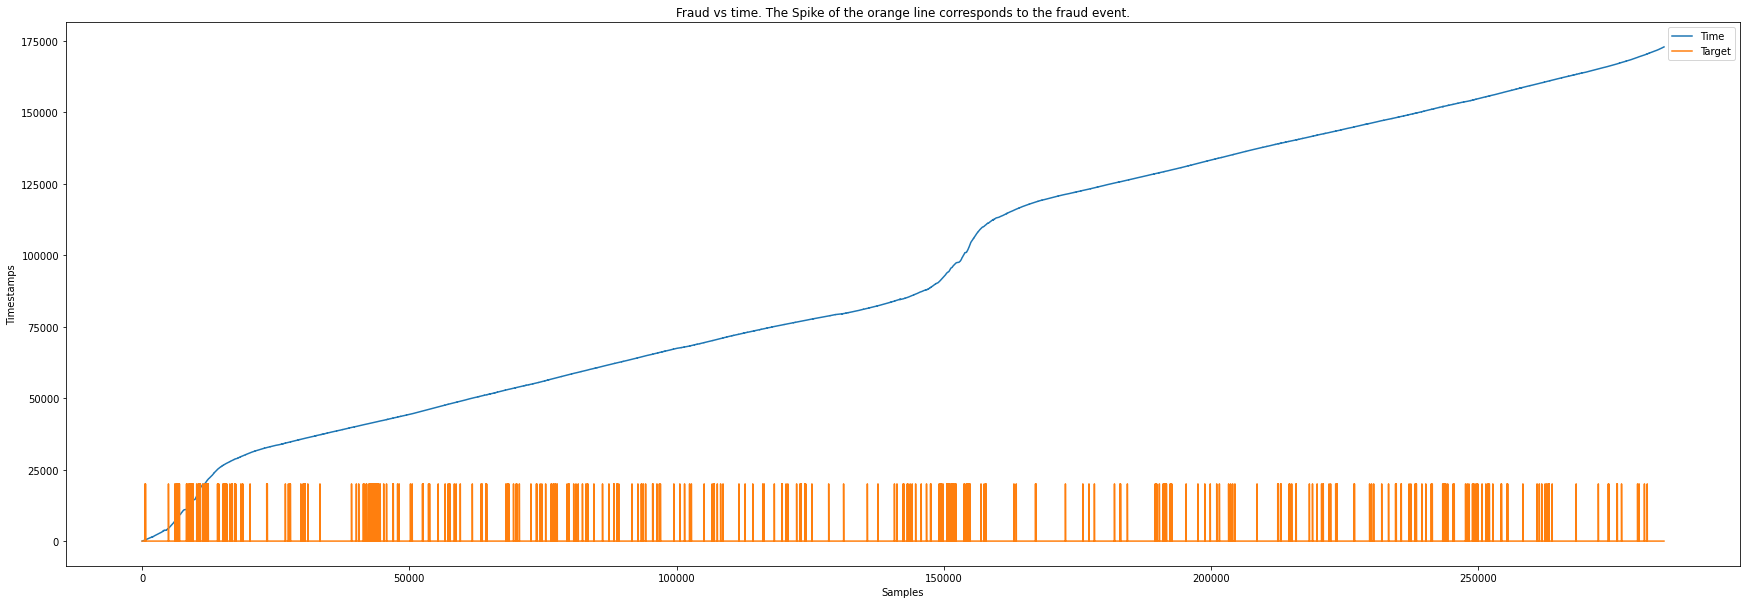

In [7]:
plt.figure(figsize=(30,10))
plt.plot(df.Time)
plt.plot(df.Class*20000)
plt.legend(['Time','Target'])
plt.xlabel('Samples')
plt.ylabel('Timestamps')
plt.title('Fraud vs time. The Spike of the orange line corresponds to the fraud event.')

### 2. Exploration of the frequency of fraud events

In [8]:
df['diff'] = df.Class.diff()
df.groupby('Class')['diff'].mean()

Class
0   -0.001636
1    0.945122
Name: diff, dtype: float64

In [9]:
df.groupby('Class')['diff'].std()

Class
0    0.040408
1    0.227974
Name: diff, dtype: float64

No handles with labels found to put in legend.


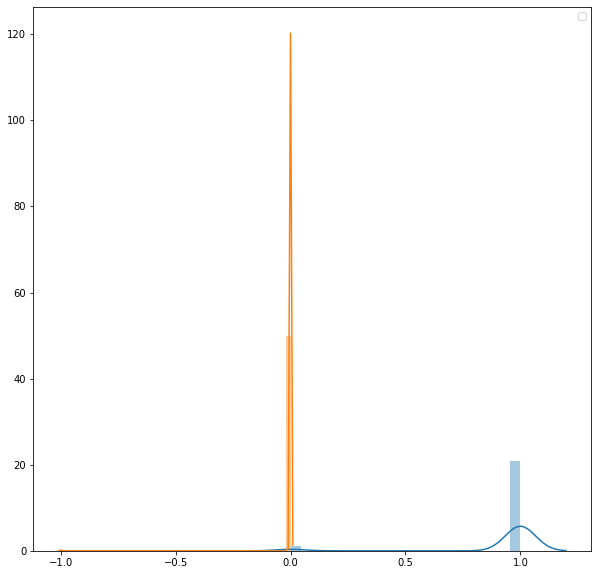

In [10]:
plt.figure(figsize=(10,10))
sns.distplot(df[df['Class']==1]['diff'].values)
sns.distplot(df[df['Class']==0]['diff'].values)
plt.legend()

For some reason, most fraud events happens in relatively narrow time interval after the previous transaction. Probably, the fraud happens automatically when if the user prived with credit card infomation on fraud website.

### 3. Proportion of fraud events over fixed time peroids

<AxesSubplot:xlabel='Class'>

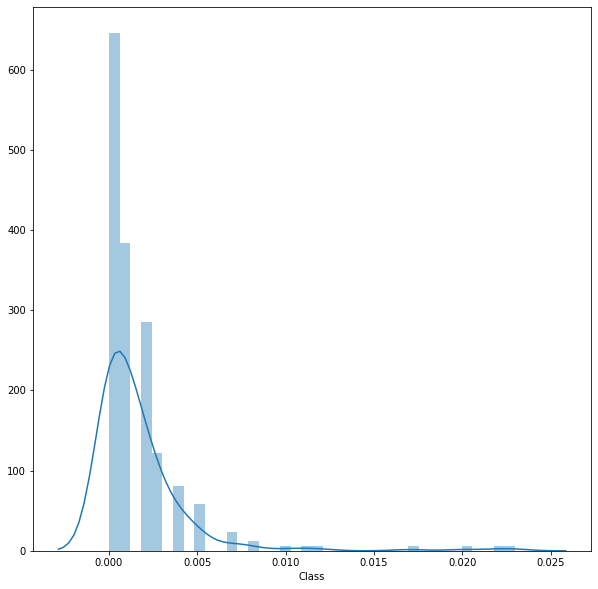

In [11]:
time_period = 1000
time_period = [[i]*time_period for i in range(df.shape[0]//time_period)]
time_period = np.array(time_period).reshape(-1)
time_period = np.append(time_period,np.zeros((df.shape[0]-time_period.shape[0]))+time_period[-1]).astype(np.int32)

df['time_period'] = time_period

temp = df.groupby('time_period')['Class'].mean()

plt.figure(figsize=(10,10))
sns.distplot(temp)

### 2. Exploration of the frequency of fraud events

Text(0.5, 1.0, 'Fraud vs time. The Spike of the orange line corresponds to the fraud event.')

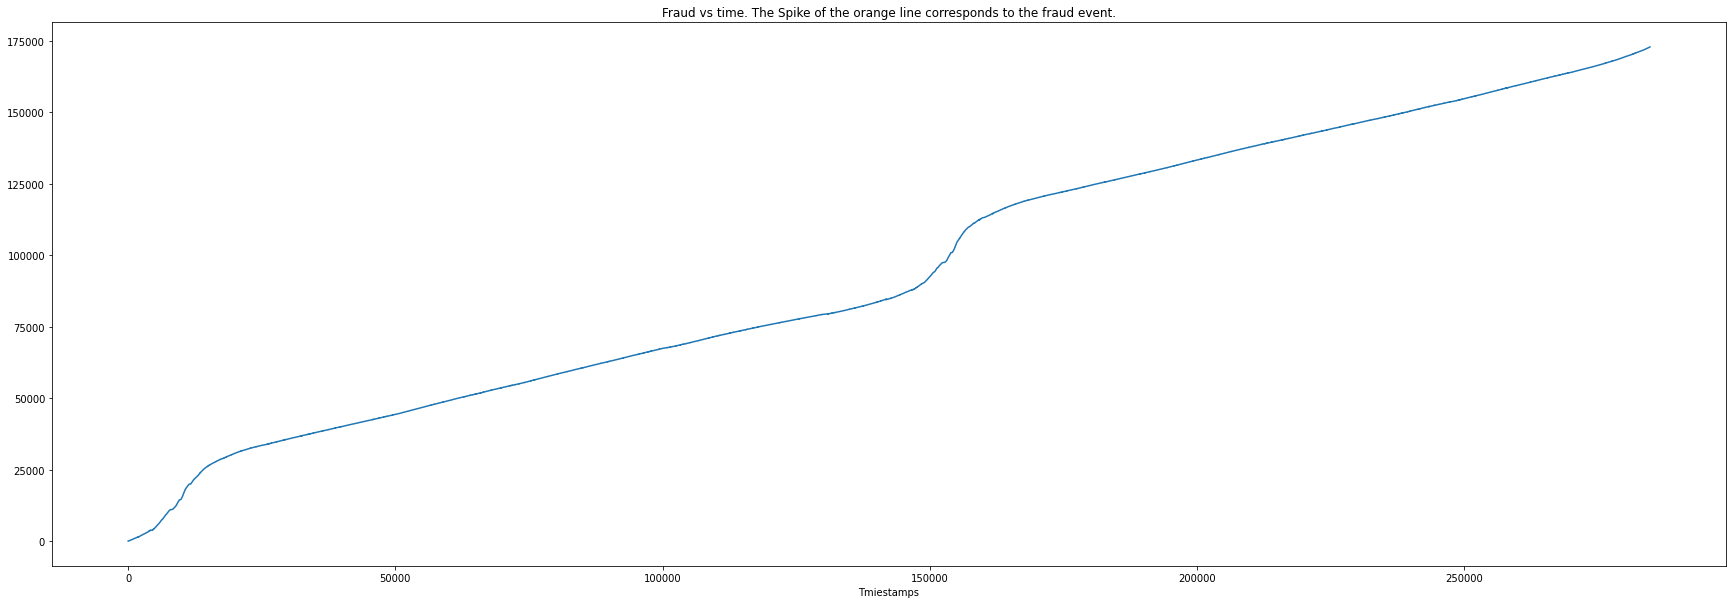

In [12]:
plt.figure(figsize=(30,10))
plt.plot(df.Time)
plt.xlabel('Samples')
plt.xlabel('Tmiestamps')
plt.title('Fraud vs time. The Spike of the orange line corresponds to the fraud event.')

Text(0.5, 1.0, 'Fraud vs time. The Spike of the orange line corresponds to the fraud event.')

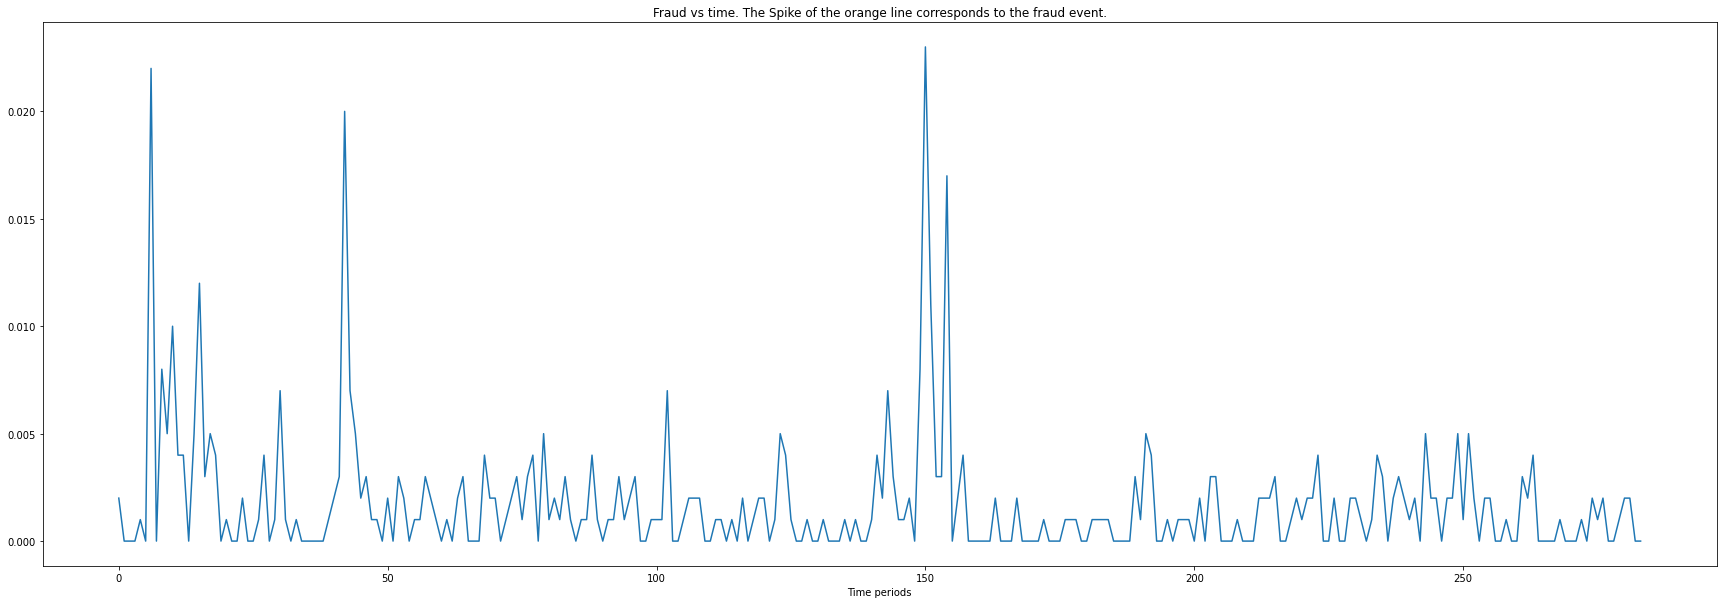

In [13]:
plt.figure(figsize=(30,10))
plt.plot(temp)
plt.xlabel('Samples')
plt.xlabel('Time periods')
plt.title('Fraud vs time. The Spike of the orange line corresponds to the fraud event.')

Conclusions:

Fraud attacks happens more often periodically, and the cross-validation strategy should take it on the account.

# Exploritary data analysis: Features

## Correlation plot

In [14]:
df = df.drop(['diff','time_period'],axis=1)
corr = df.corr()
corr = corr.abs() #abs to estimate the absolute importance towards the target
corr.style.background_gradient(cmap='coolwarm')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,0.117396,0.010593,0.419618,0.105260,0.173072,0.063016,0.084714,0.036949,0.008660,0.030617,0.247689,0.124348,0.065902,0.098757,0.183453,0.011903,0.073297,0.090438,0.028975,0.050866,0.044736,0.144059,0.051142,0.016182,0.233083,0.041407,0.005135,0.009413,0.010596,0.012323
V1,0.117396,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.227709,0.101347
V2,0.010593,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.531409,0.091289
V3,0.419618,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.210880,0.192961
V4,0.105260,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.098732,0.133447
V5,0.173072,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.386356,0.094974
V6,0.063016,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.215981,0.043643
V7,0.084714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.397311,0.187257
V8,0.036949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.103079,0.019875
V9,0.008660,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044246,0.097733


V1-V10, V21-V23 features are highly correlated with an Amount, it seems like the're some statistics calculated over the time. 

Features V1,V2,V3,V4,V5,V7,V9,V10,V11,V12,V13,V16,V17,V18 have significally higher correlation compared to others, and, potentially have a higher importaince for building the classifier.

## Feature distributions

/home/dmitriishubin/anaconda3/envs/fraud_detection_supervised/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


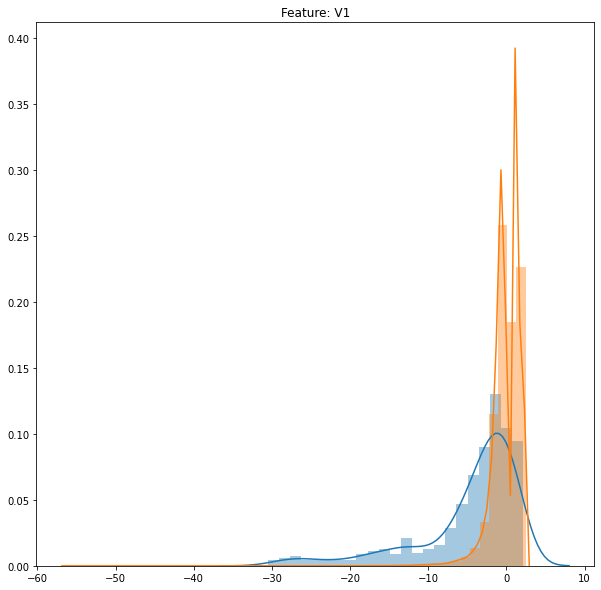

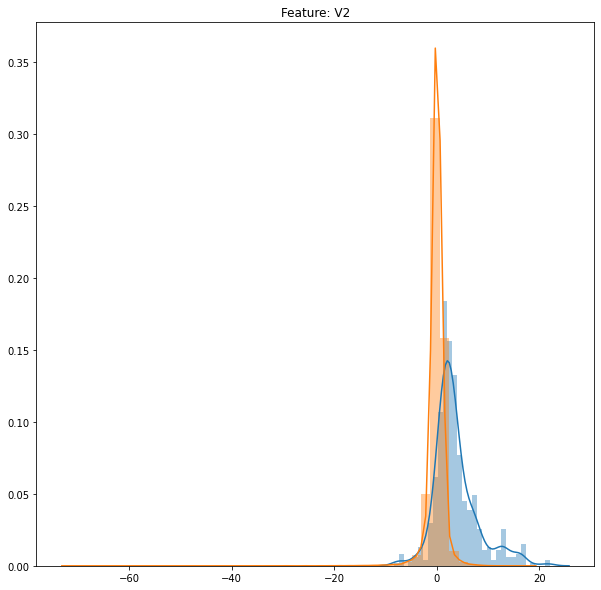

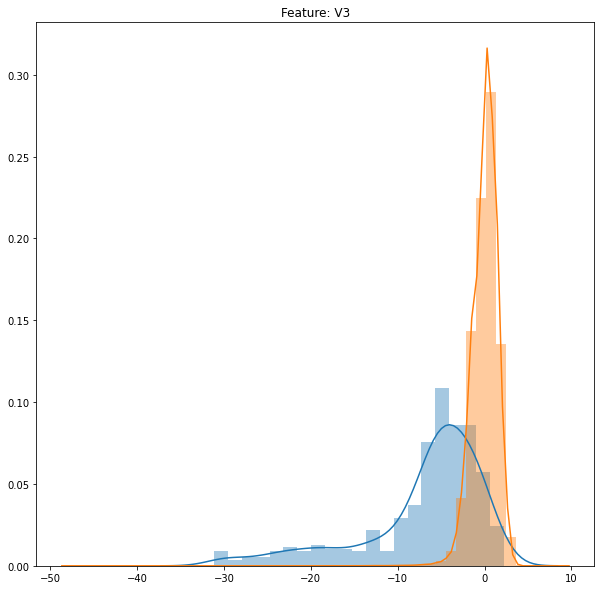

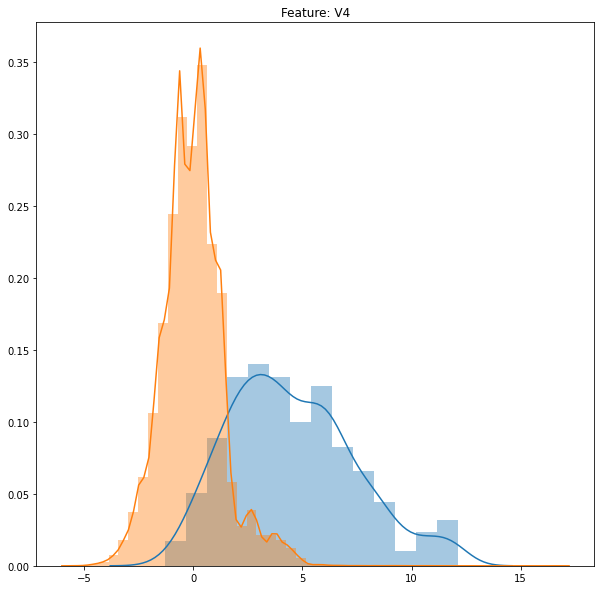

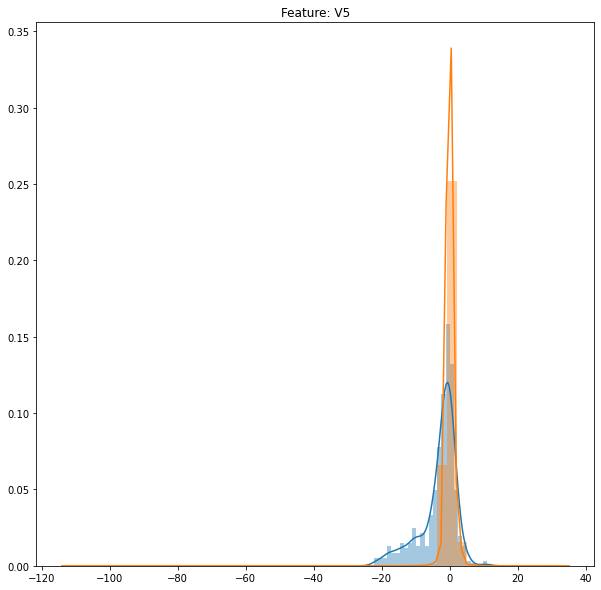

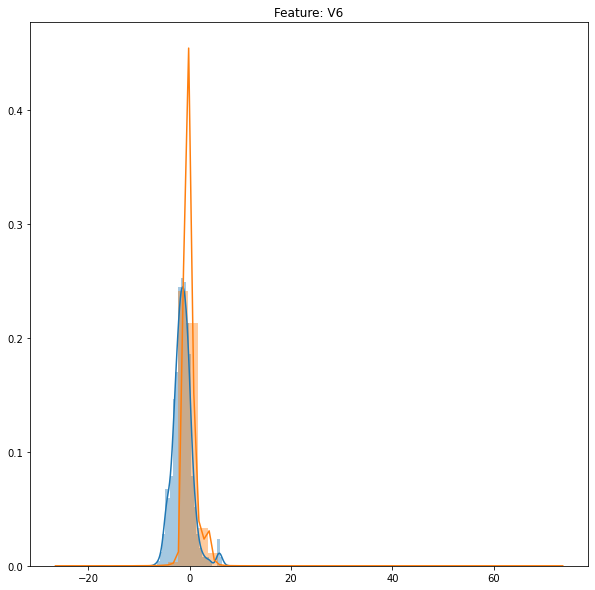

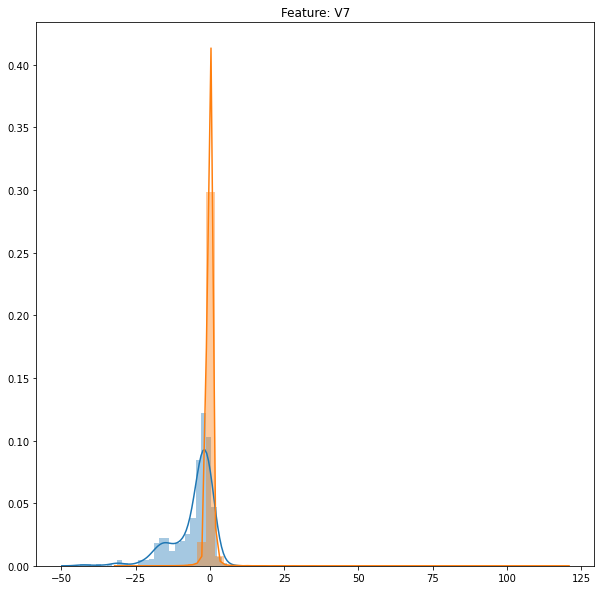

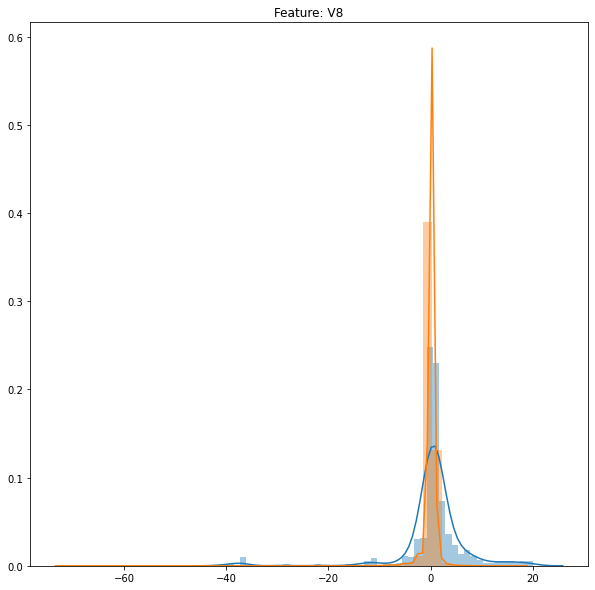

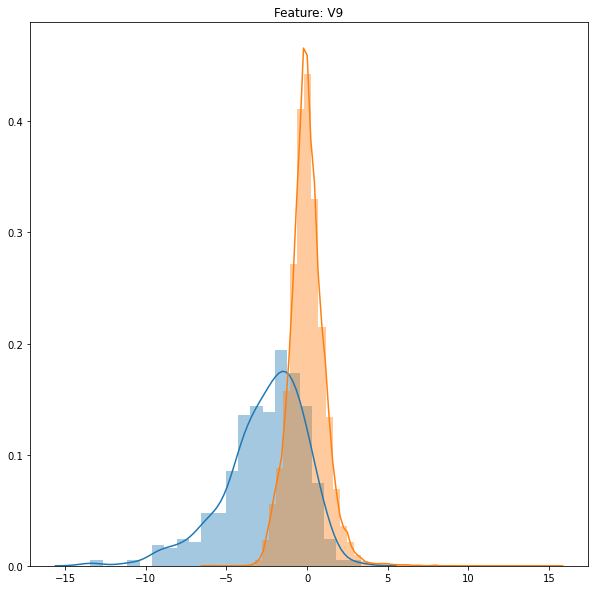

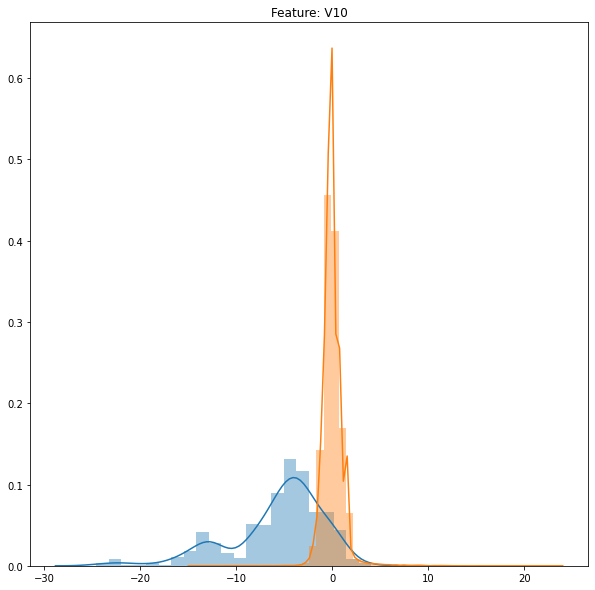

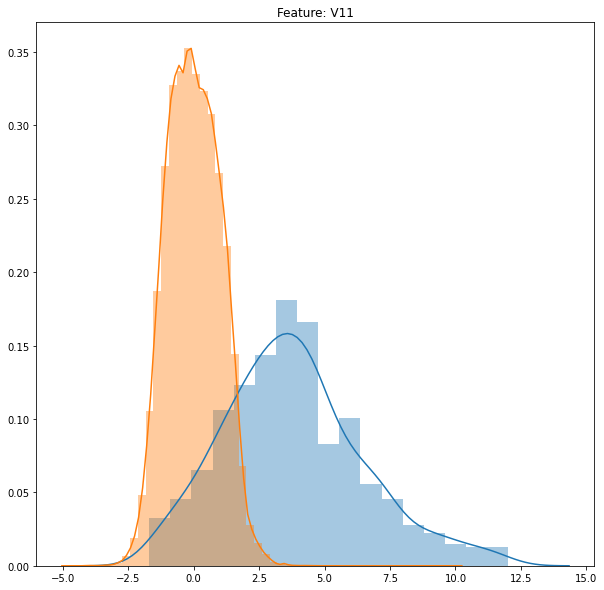

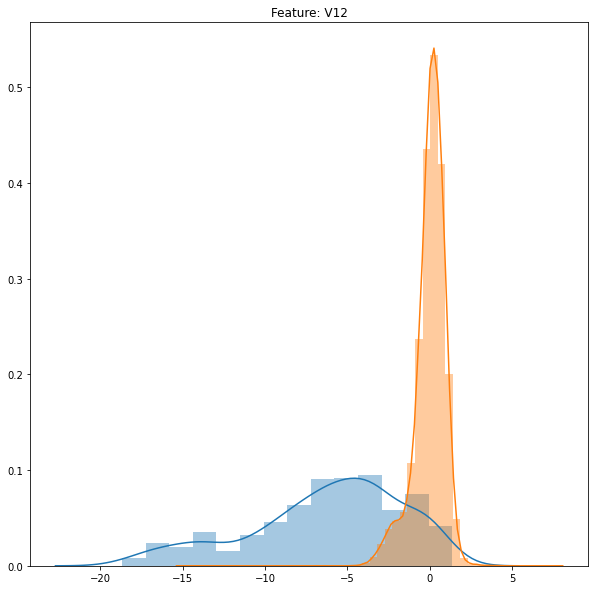

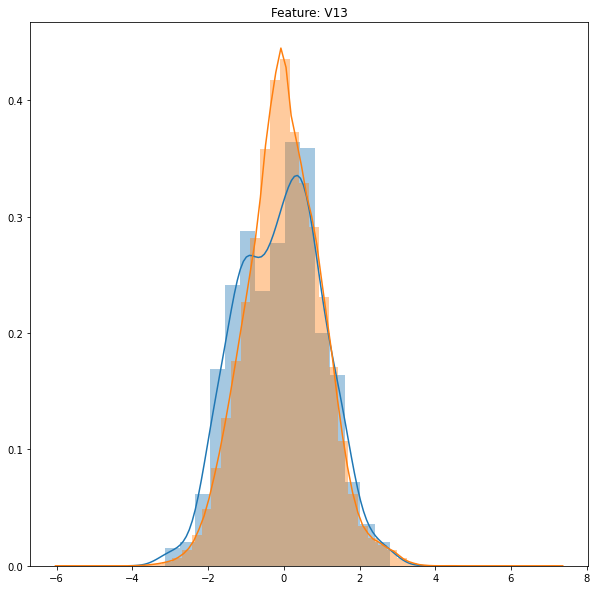

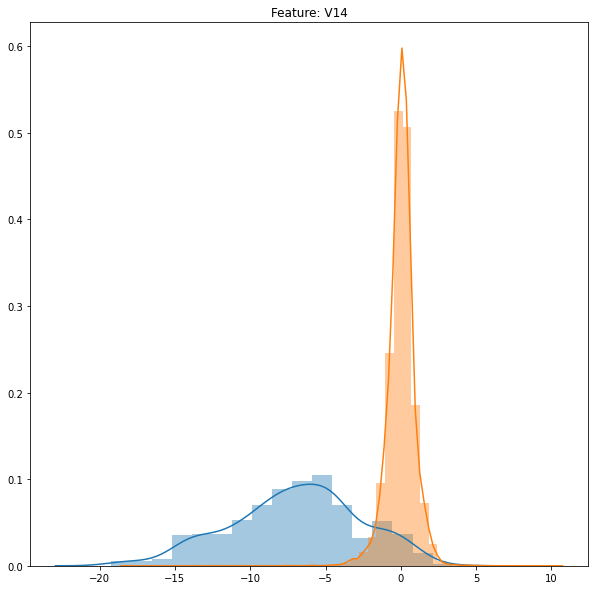

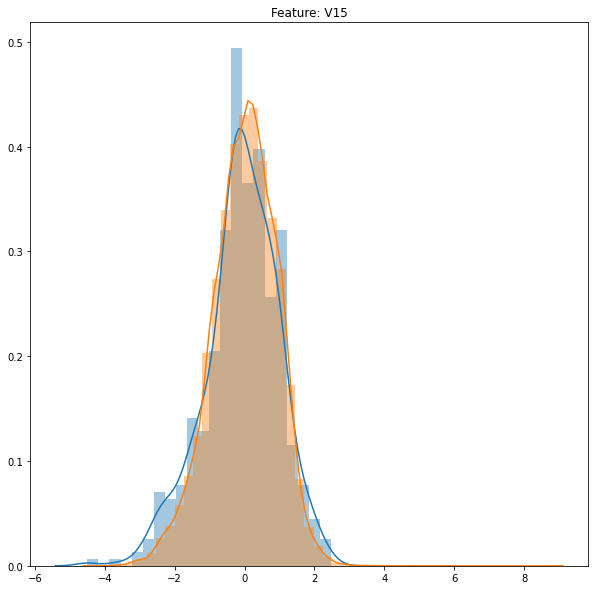

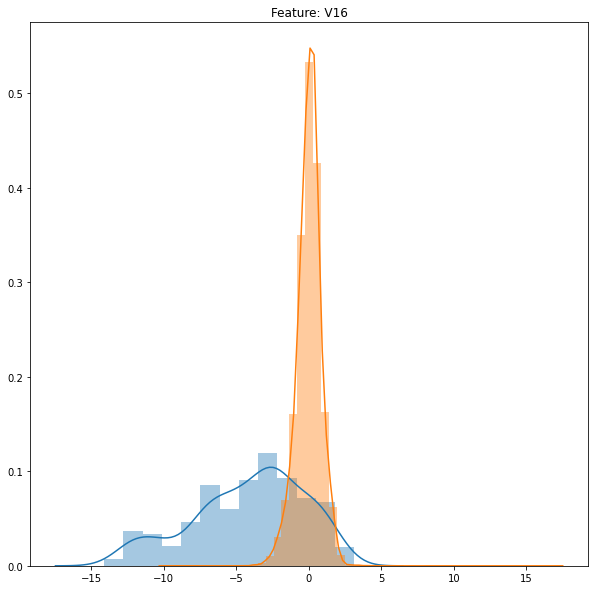

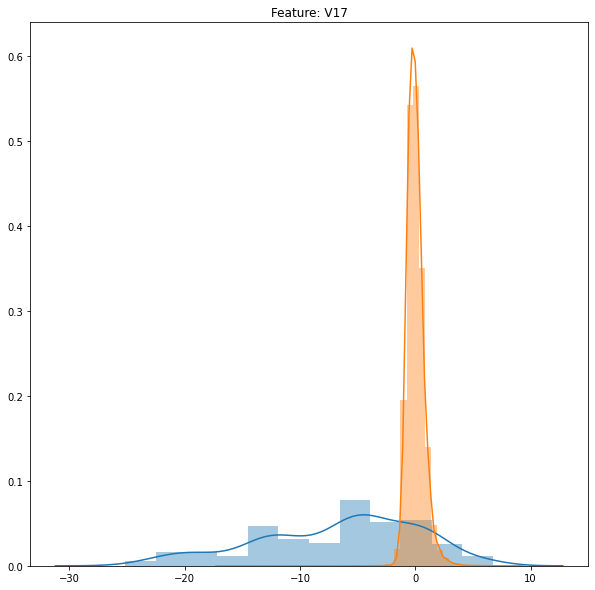

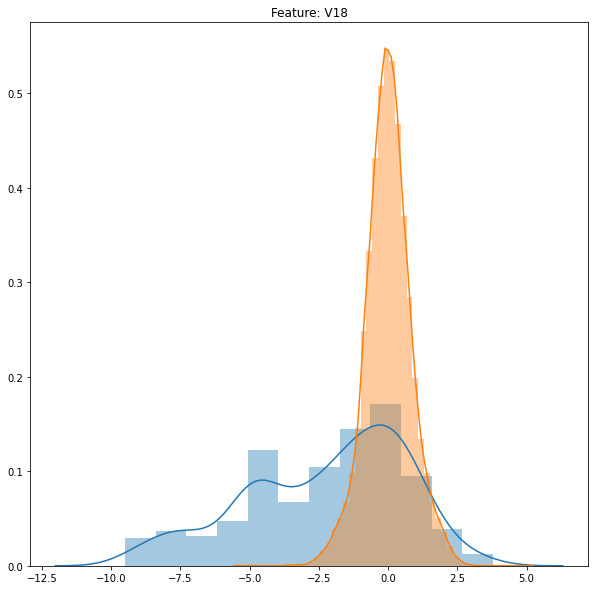

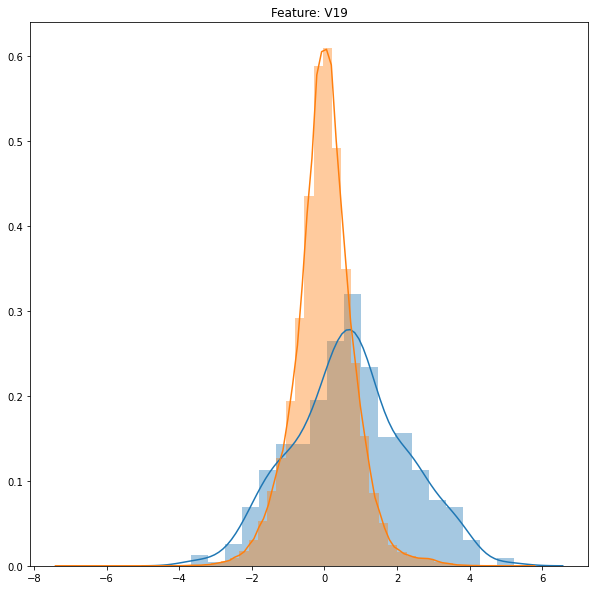

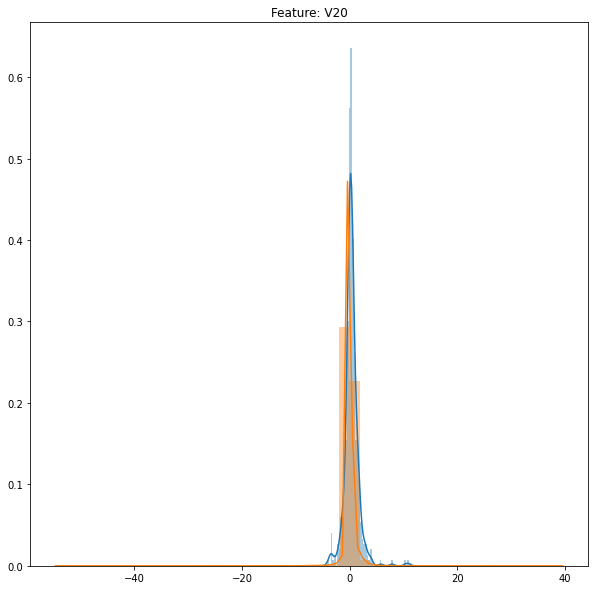

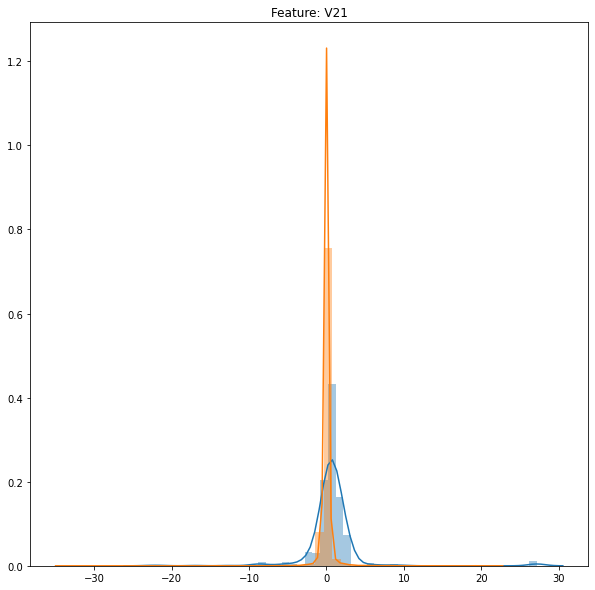

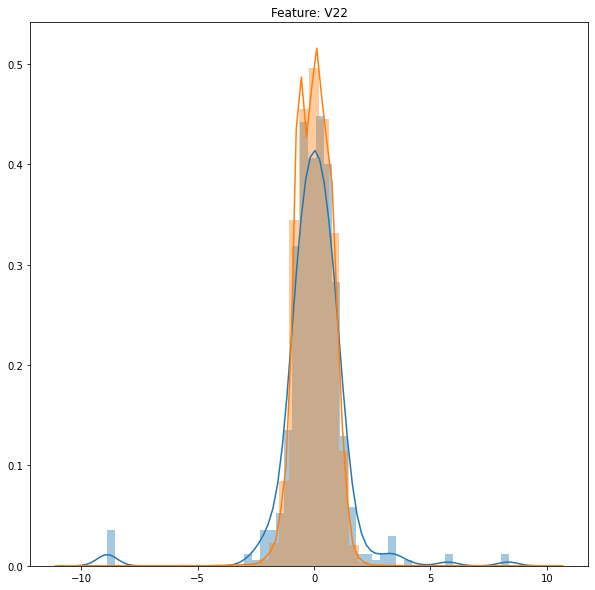

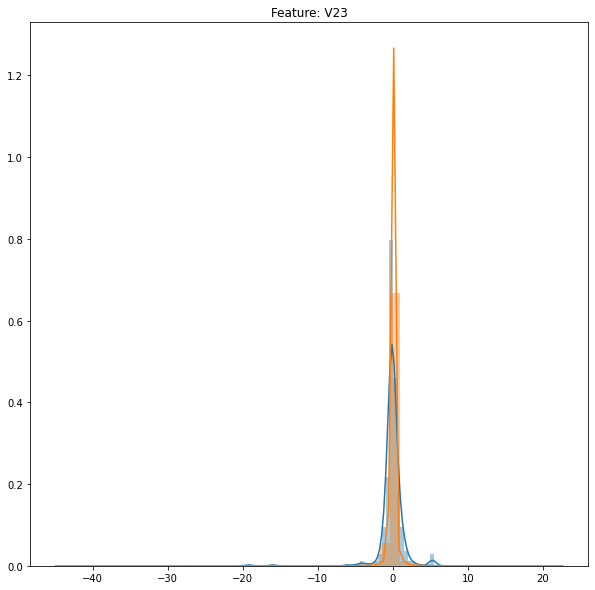

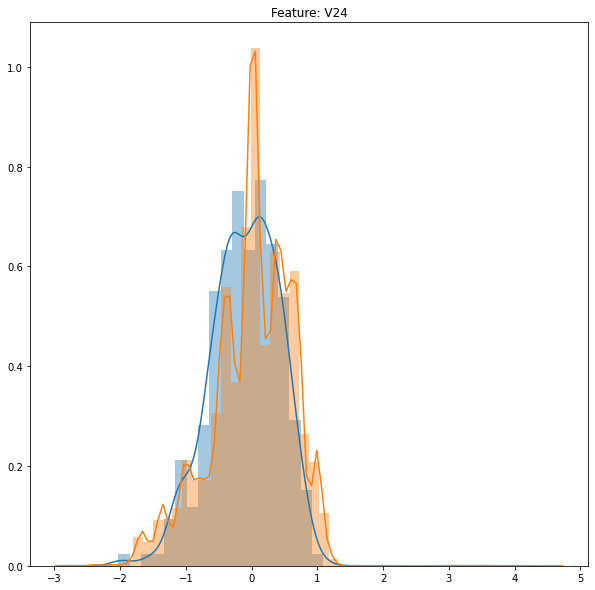

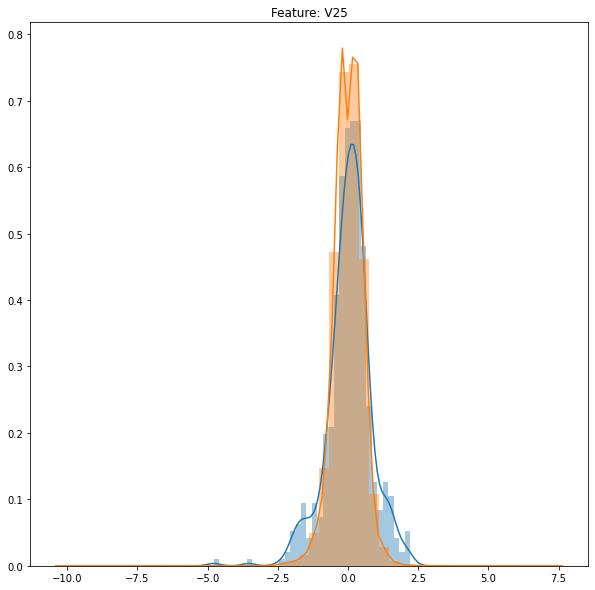

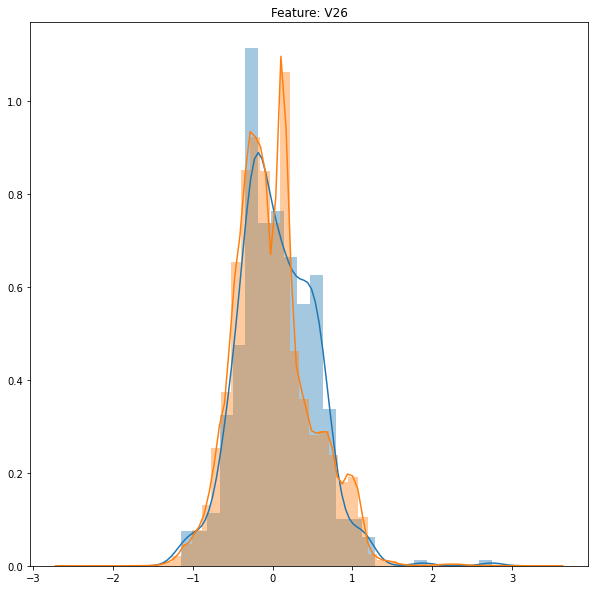

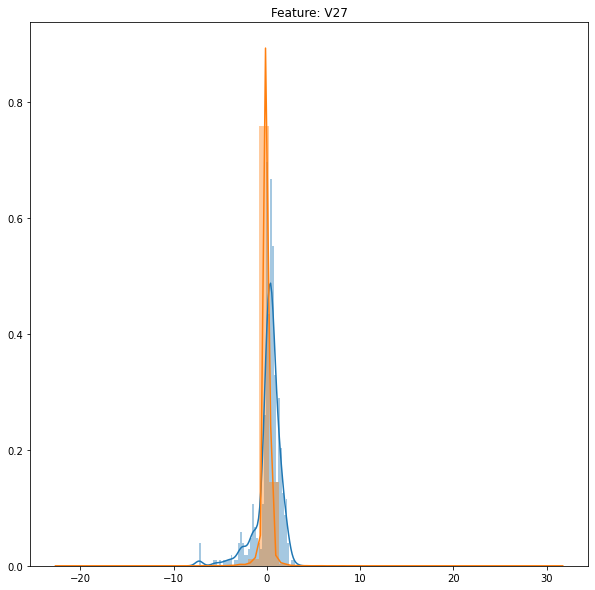

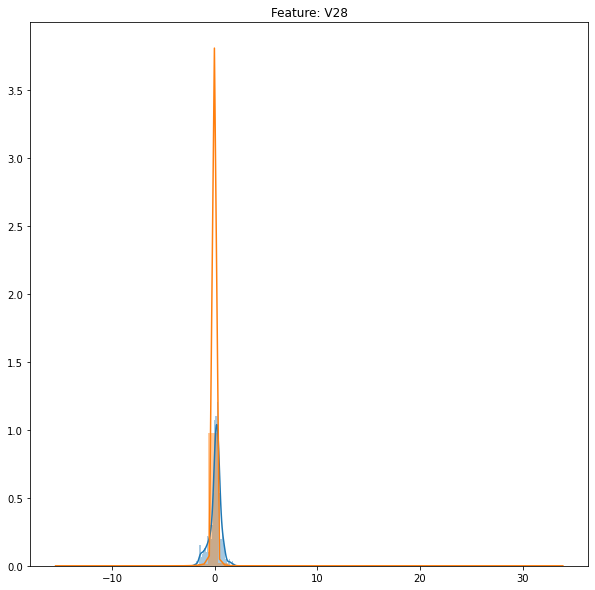

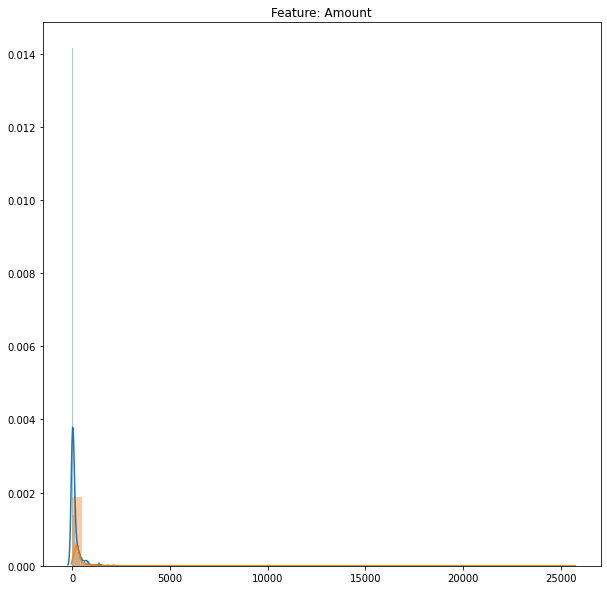

In [15]:
features = df.drop(['Class','Time'],axis=1).columns.to_list()

for feature in features:
    
    plt.figure(figsize=(10,10))
    sns.distplot(df[df.Class==1][feature].values)
    sns.distplot(df[df.Class==0][feature].values)
    plt.title(f'Feature: {feature}')
    

## Stability of features over the time

/home/dmitriishubin/anaconda3/envs/fraud_detection_supervised/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


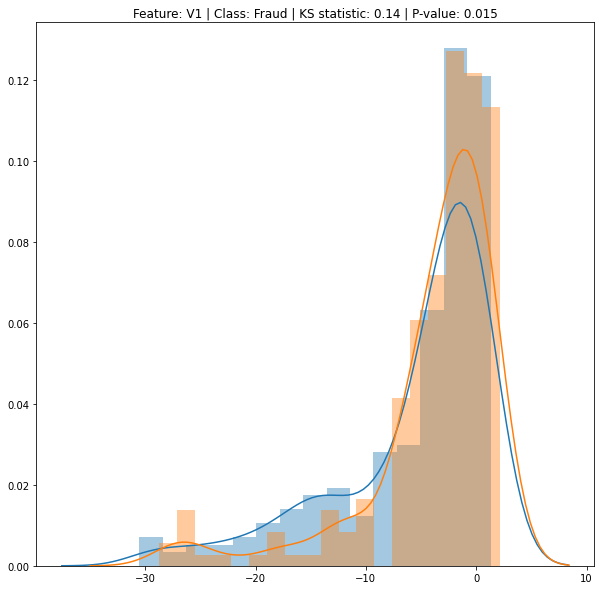

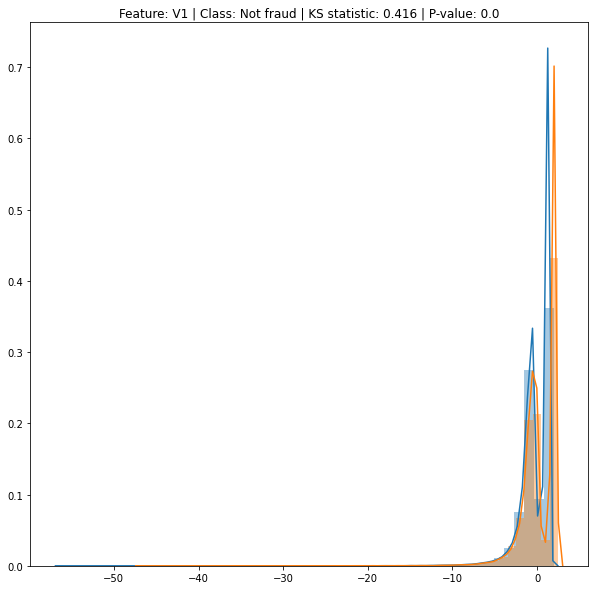

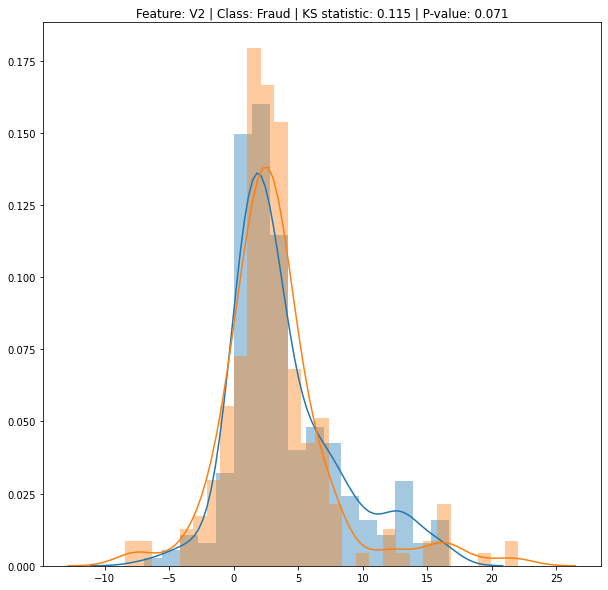

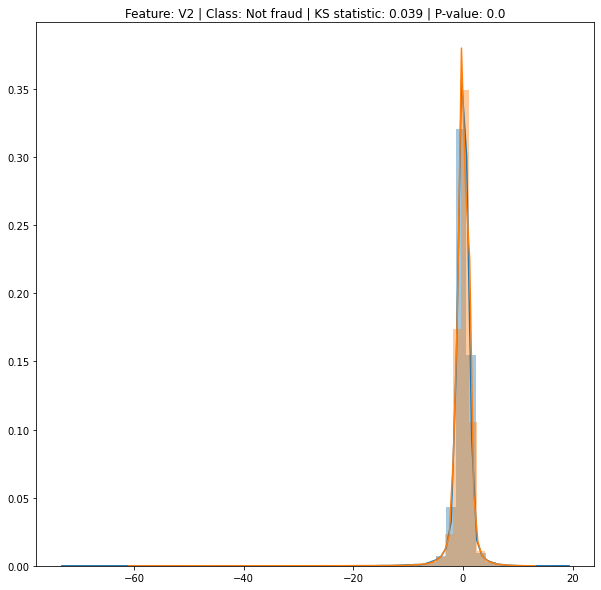

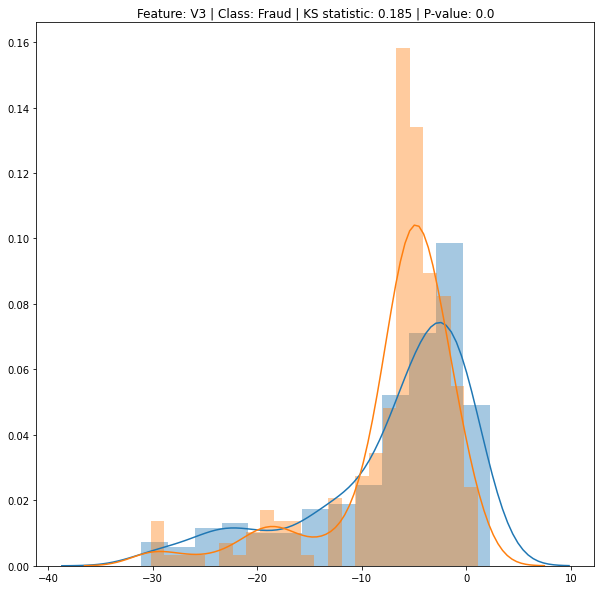

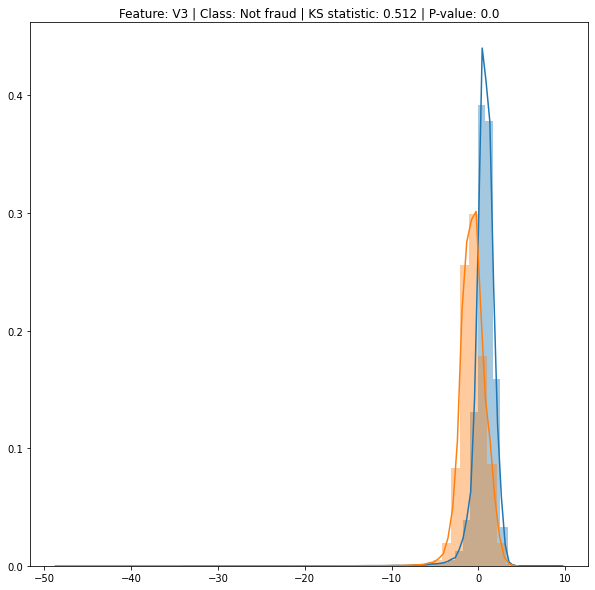

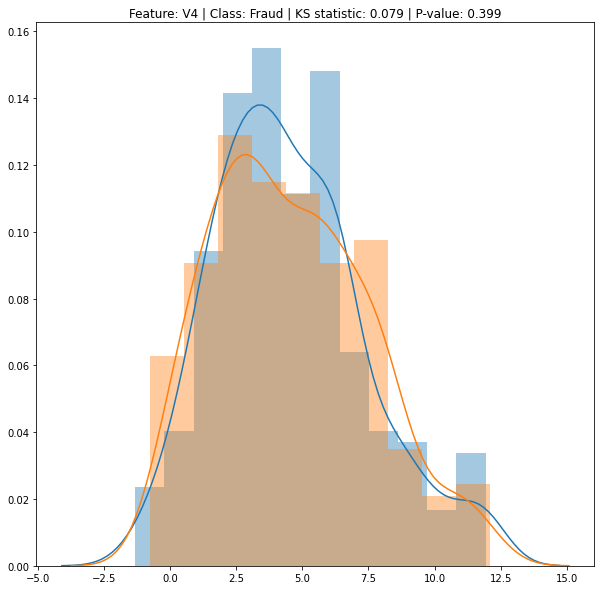

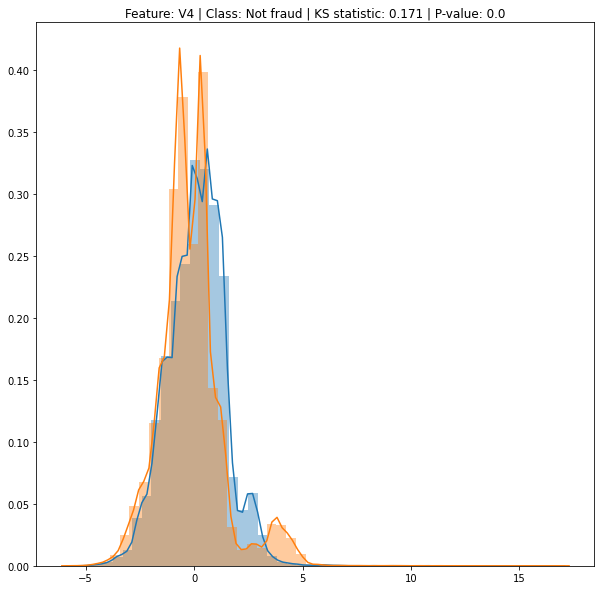

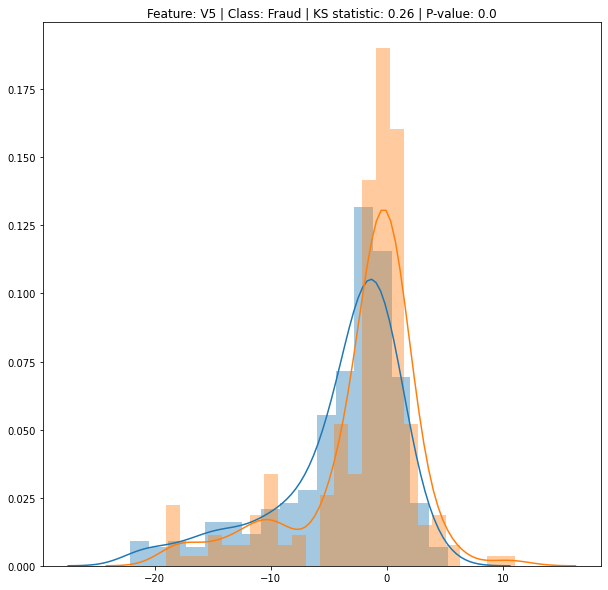

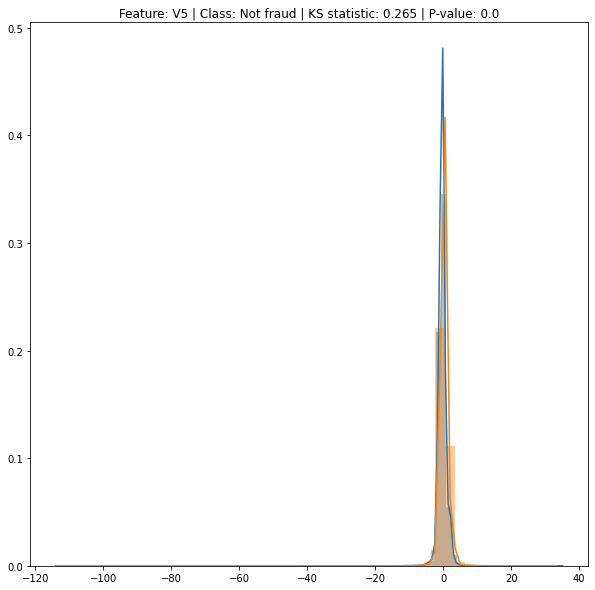

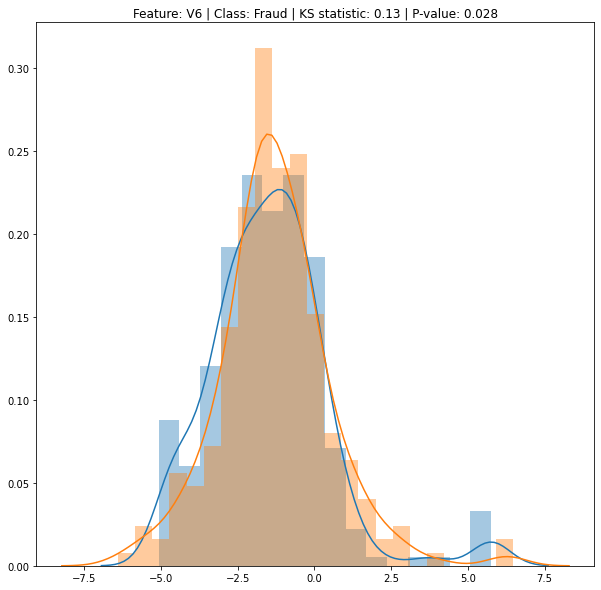

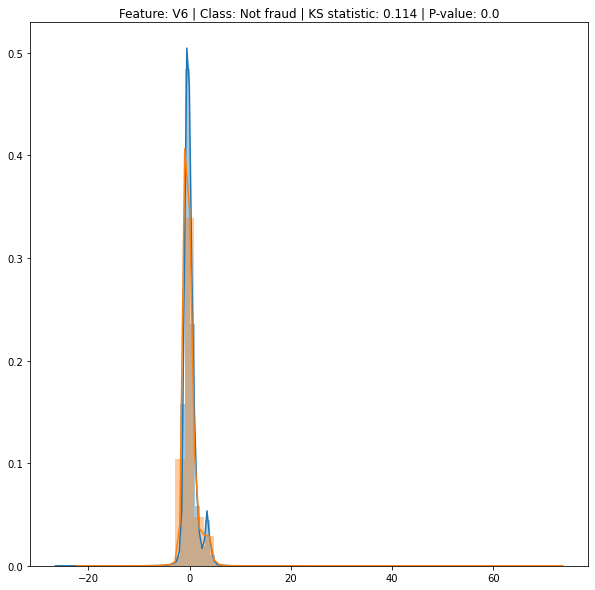

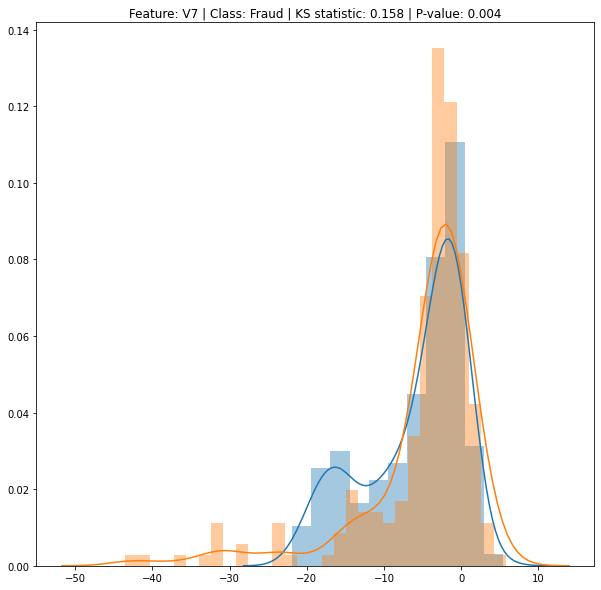

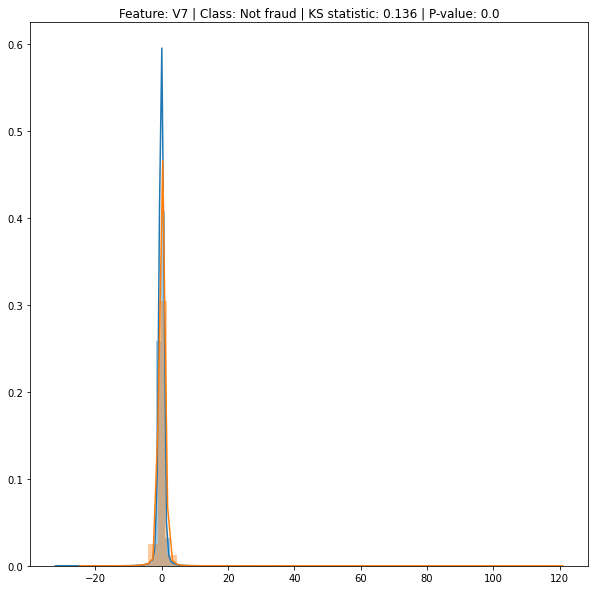

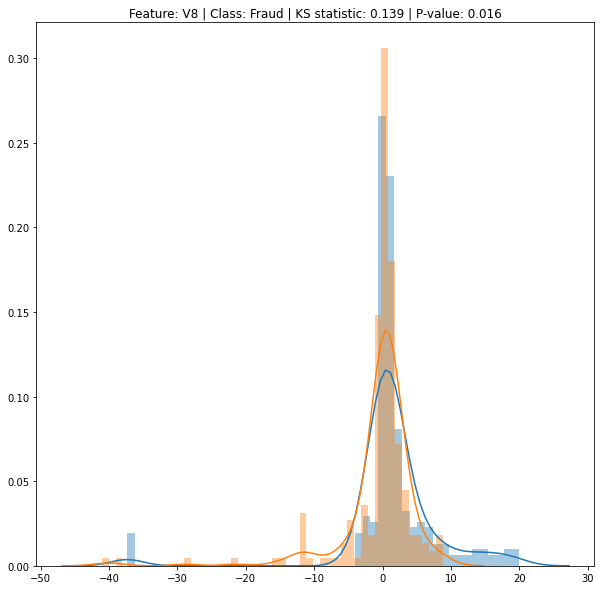

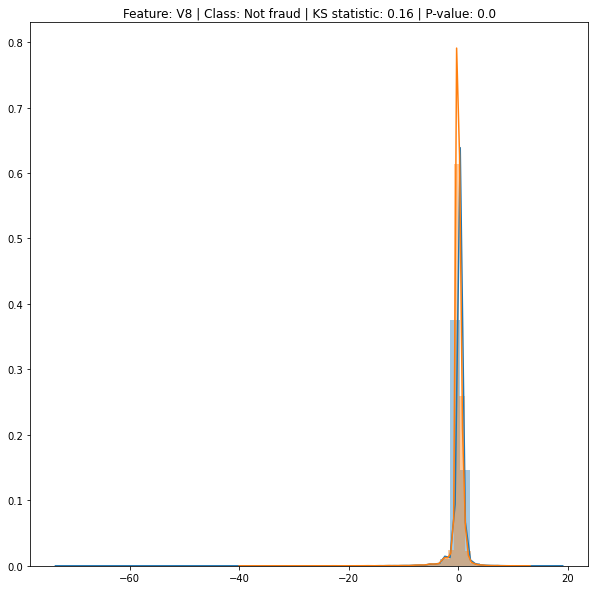

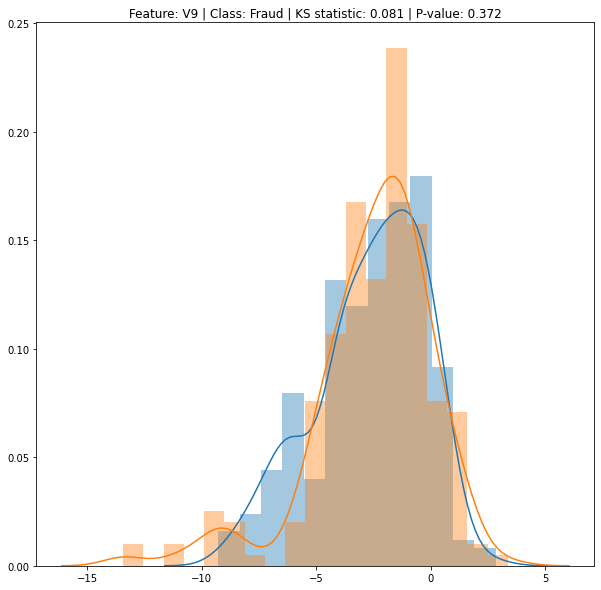

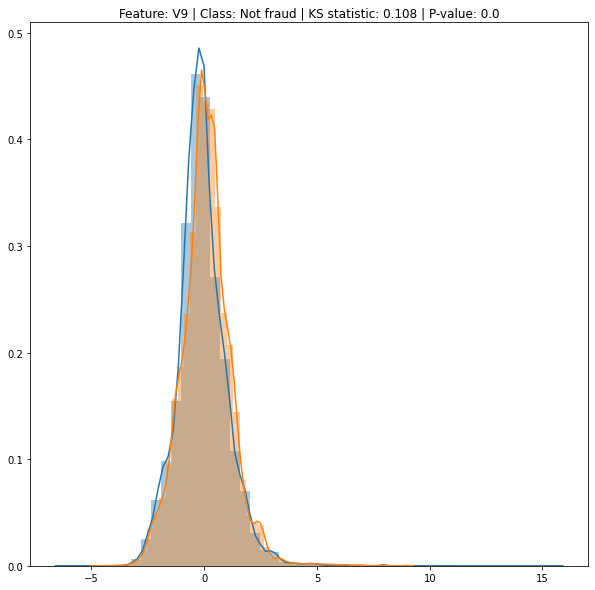

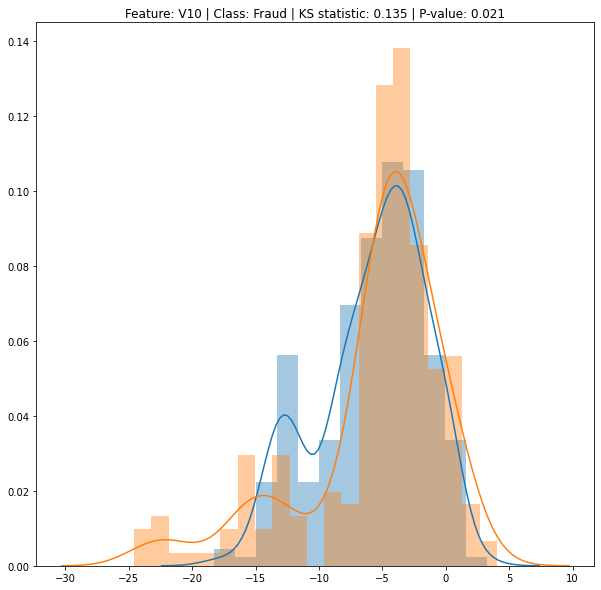

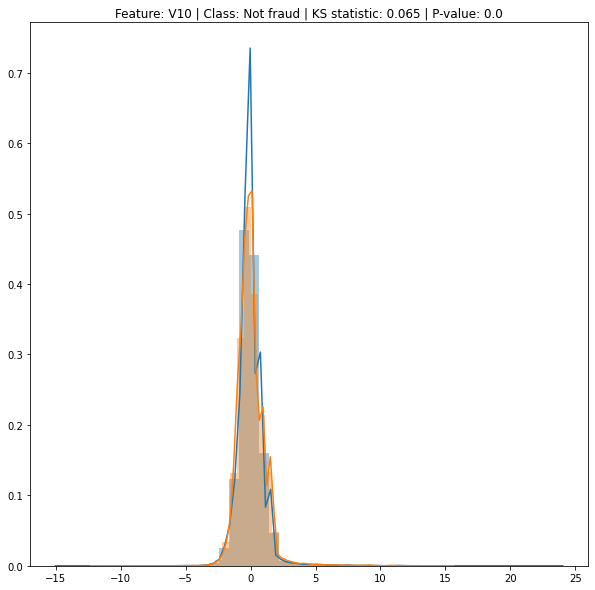

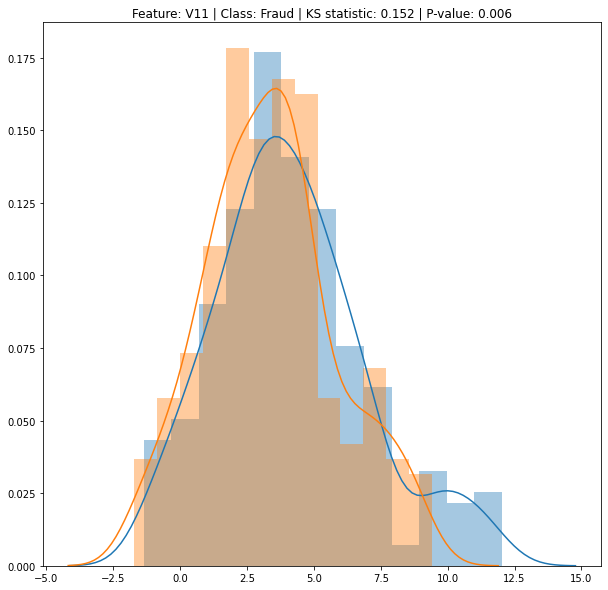

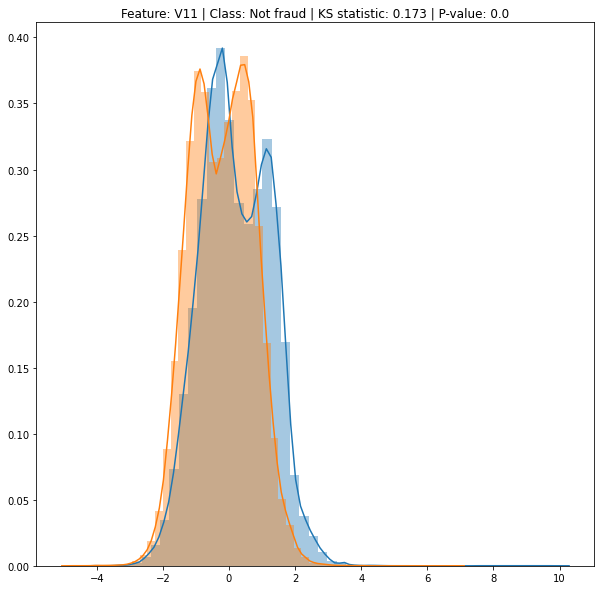

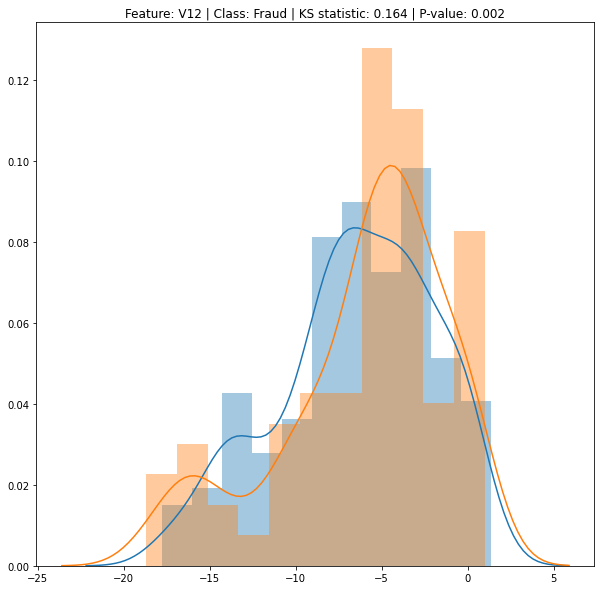

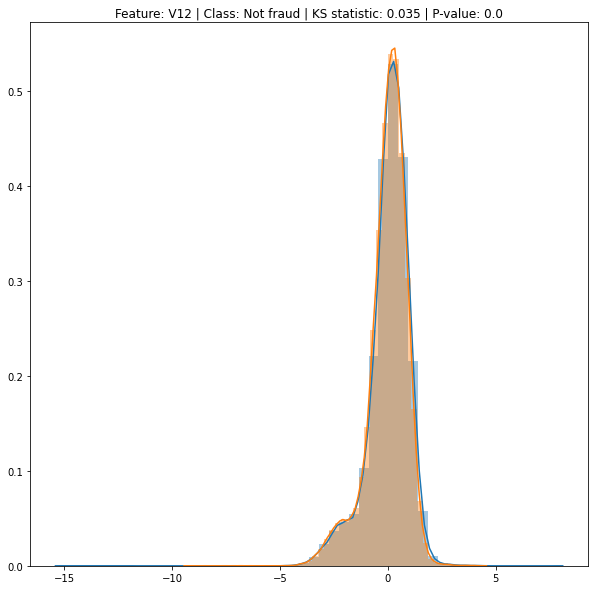

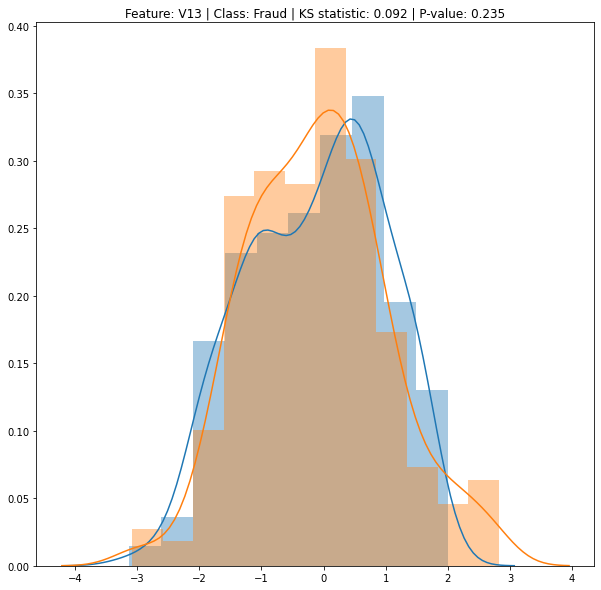

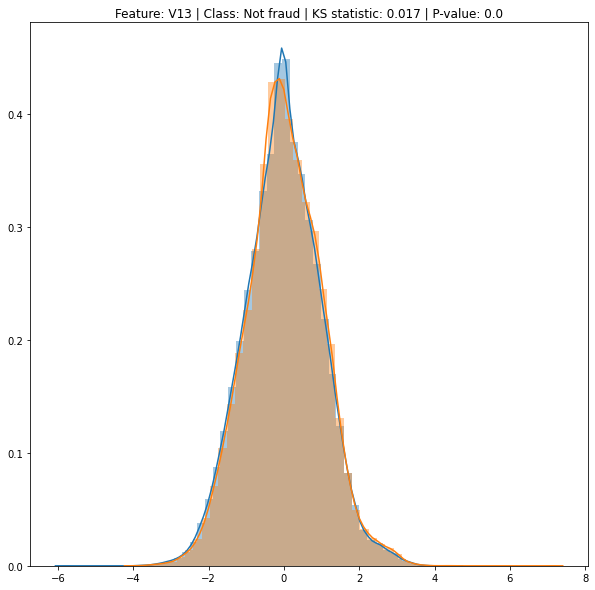

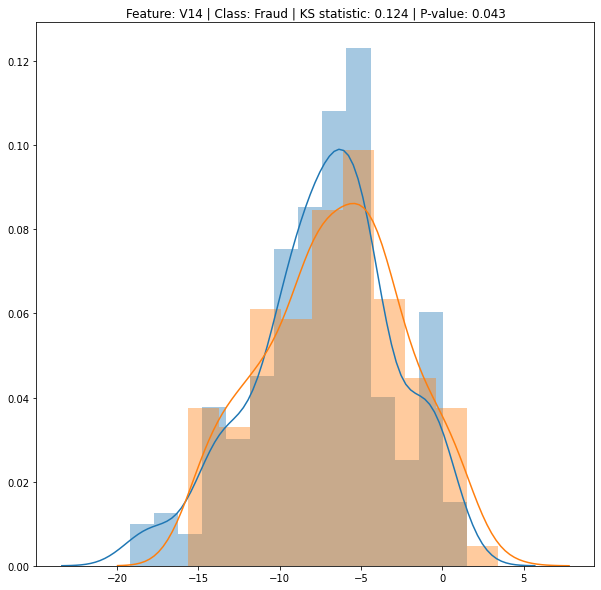

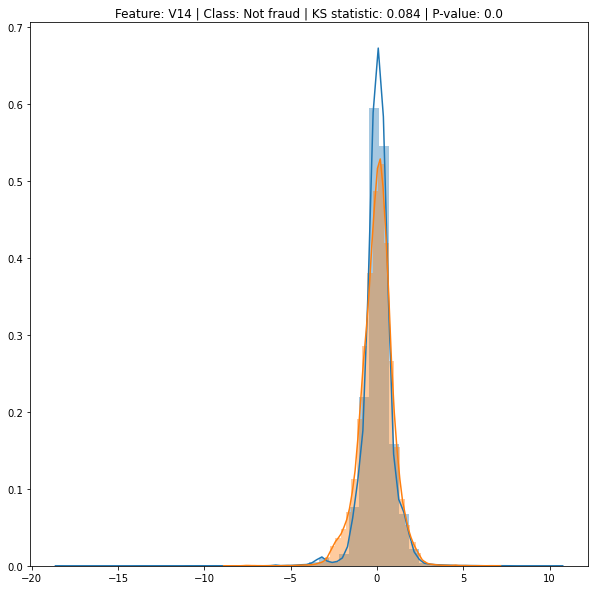

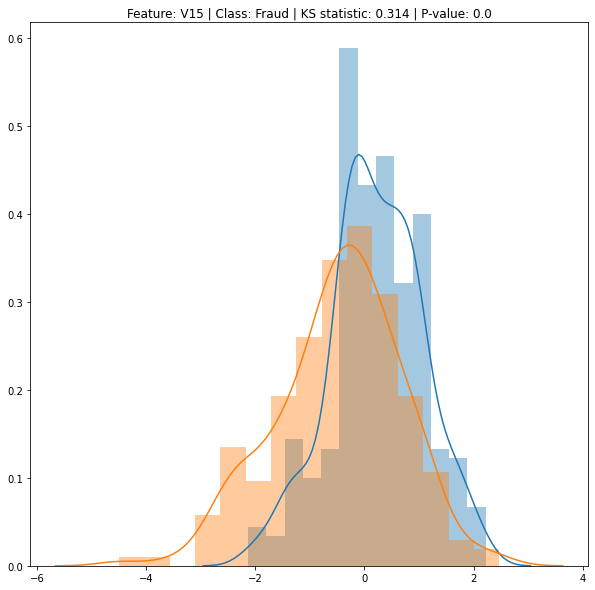

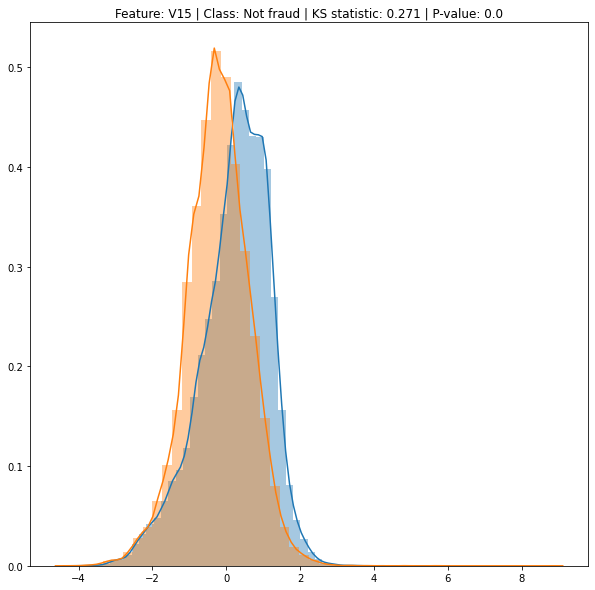

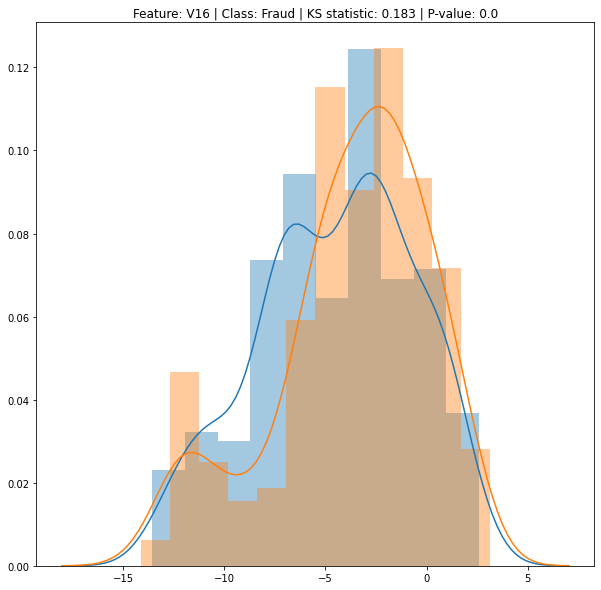

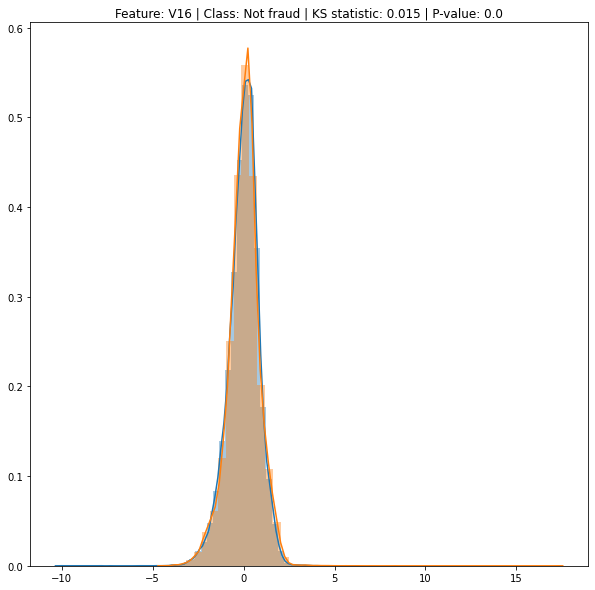

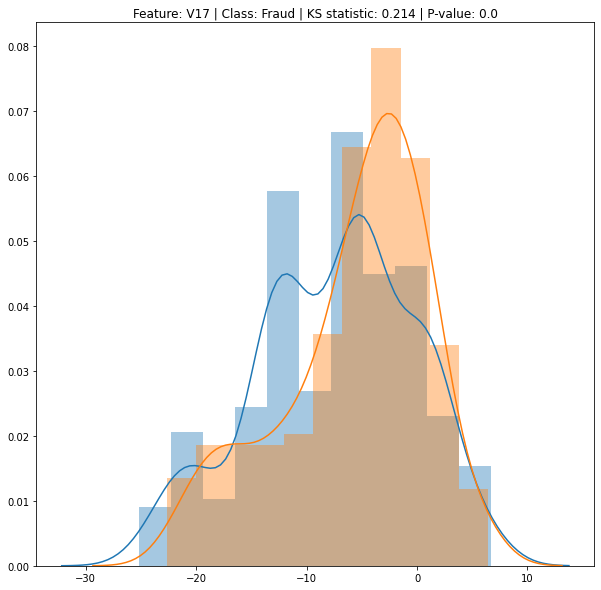

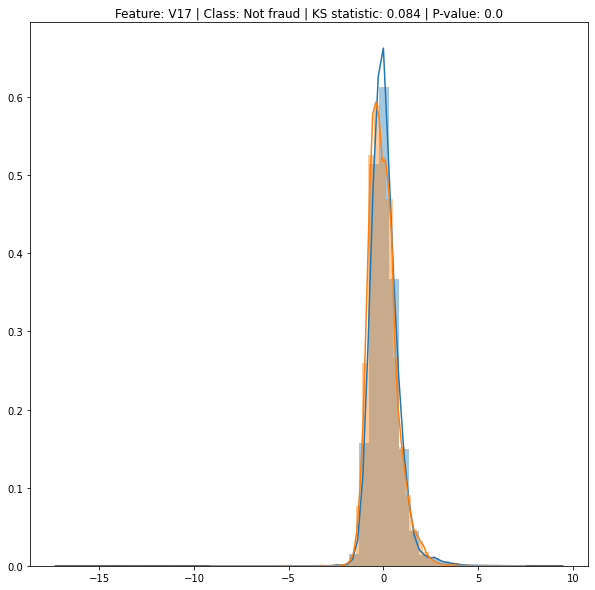

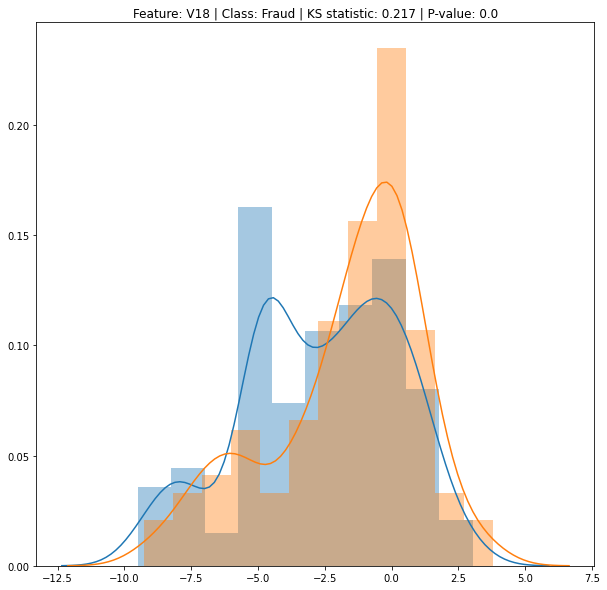

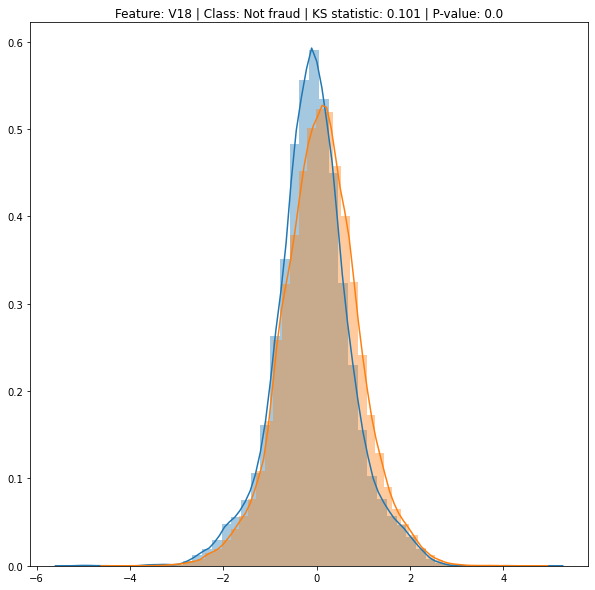

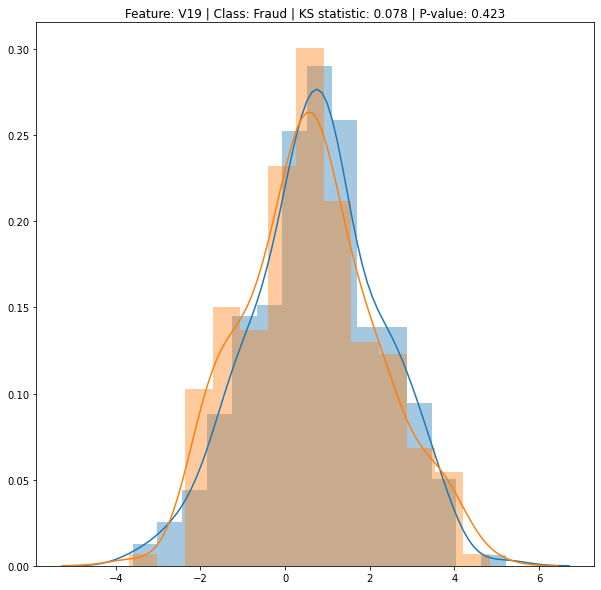

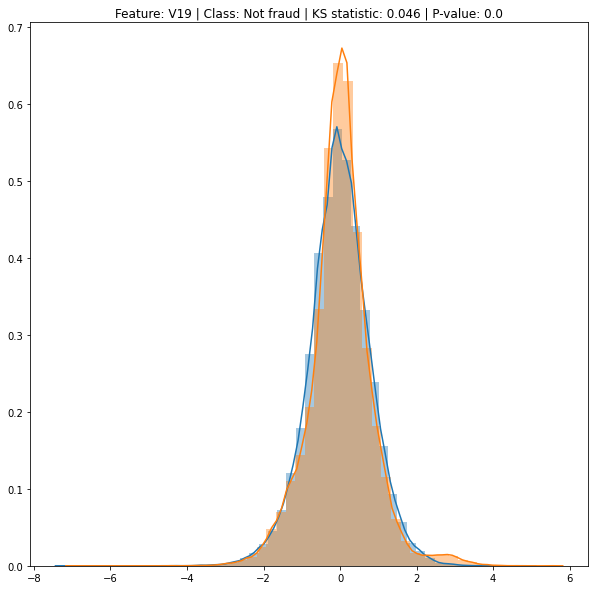

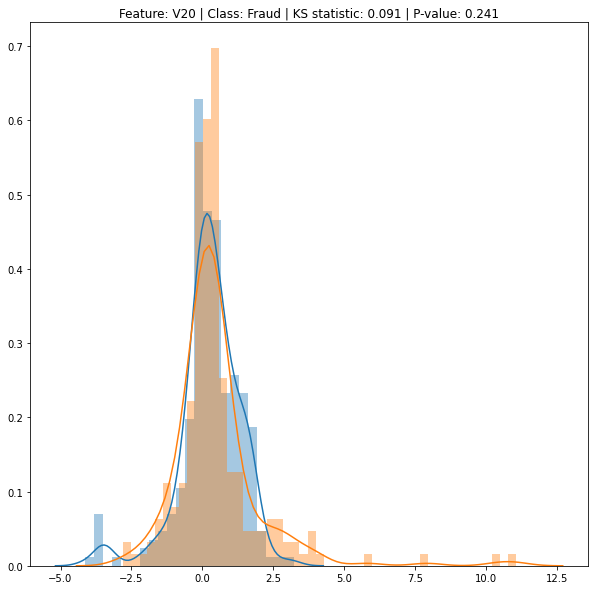

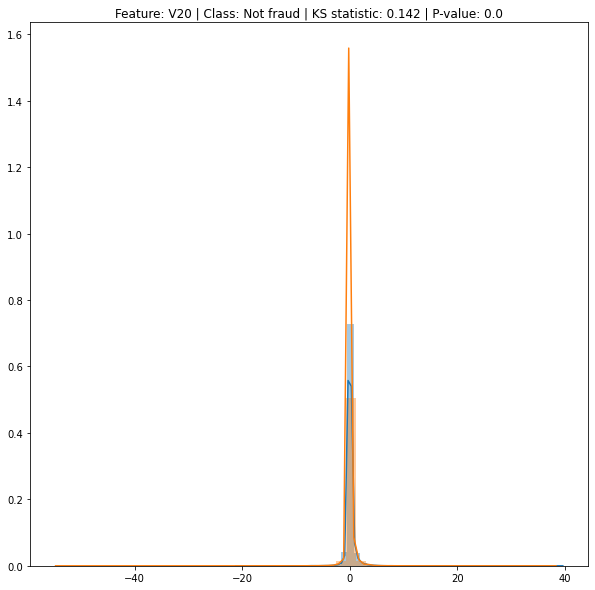

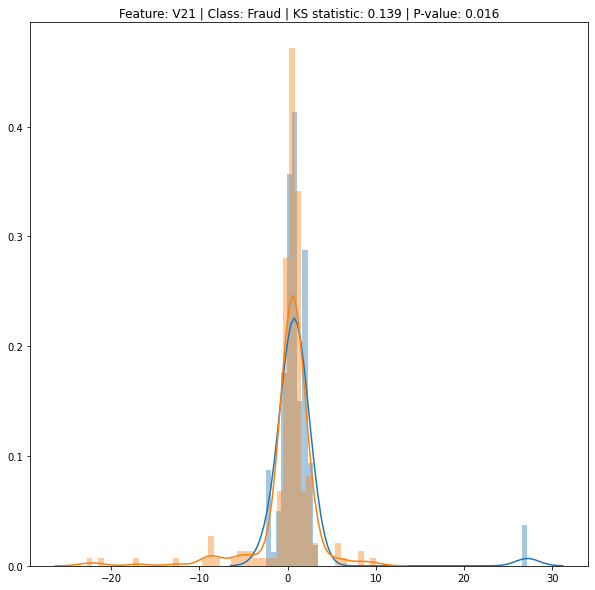

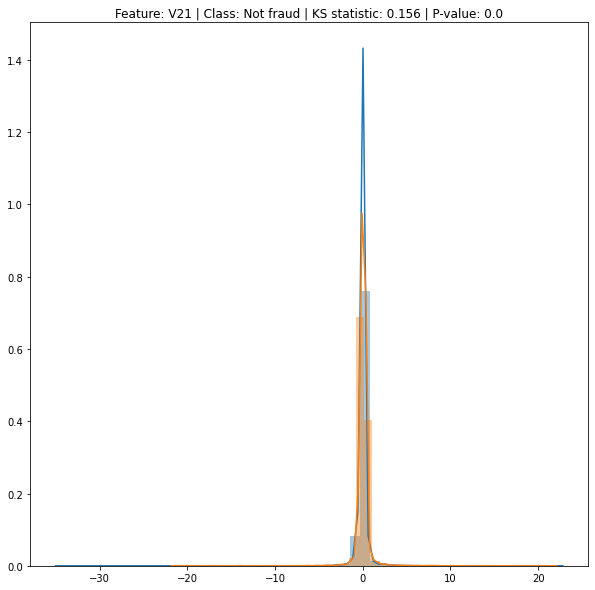

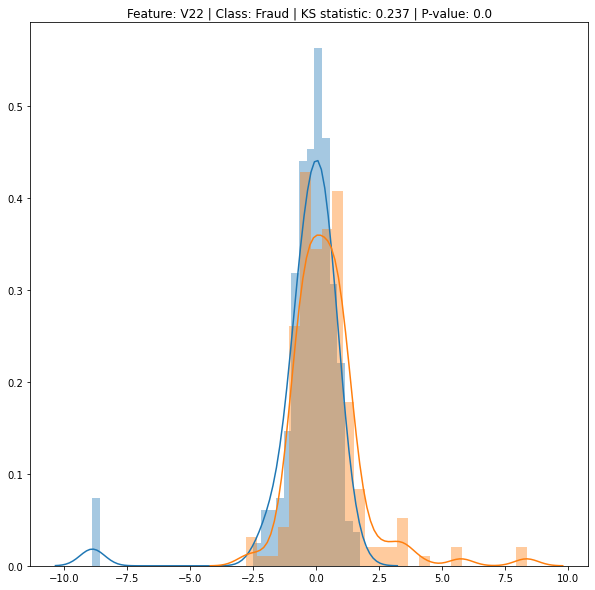

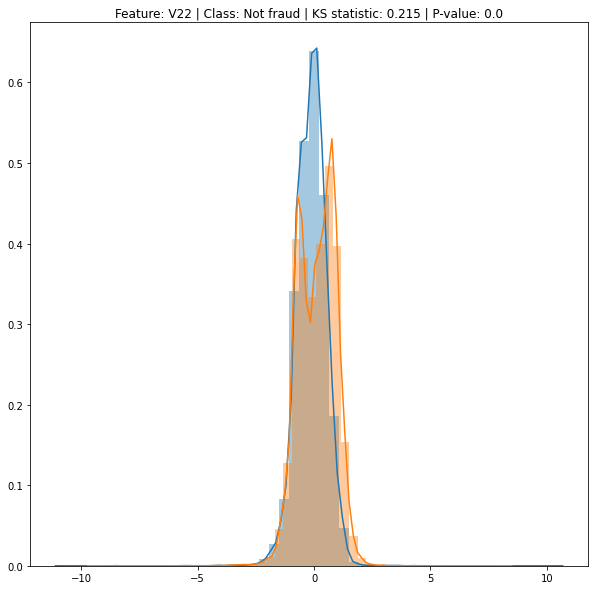

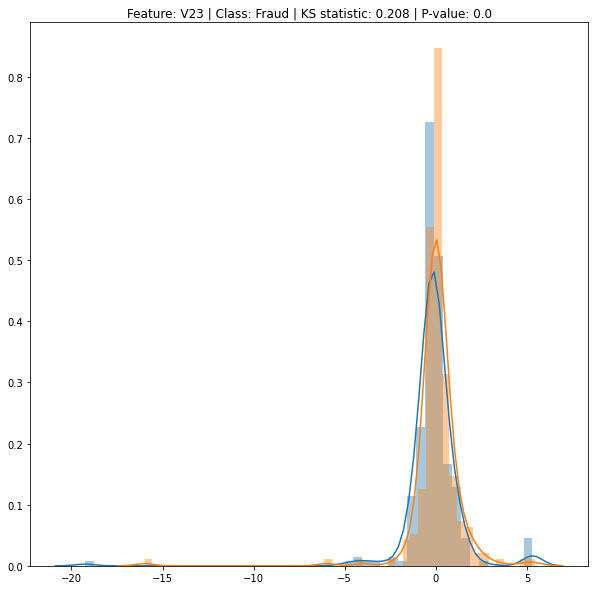

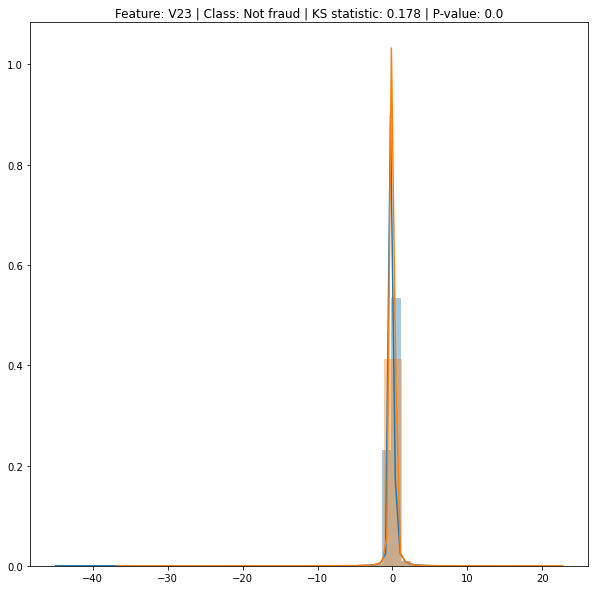

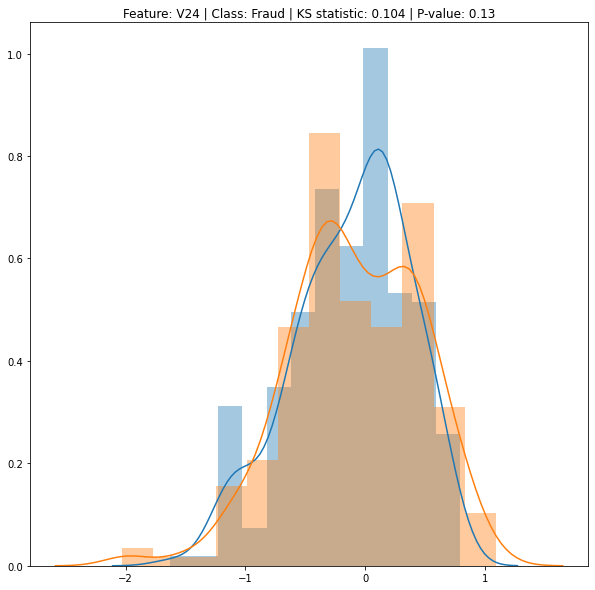

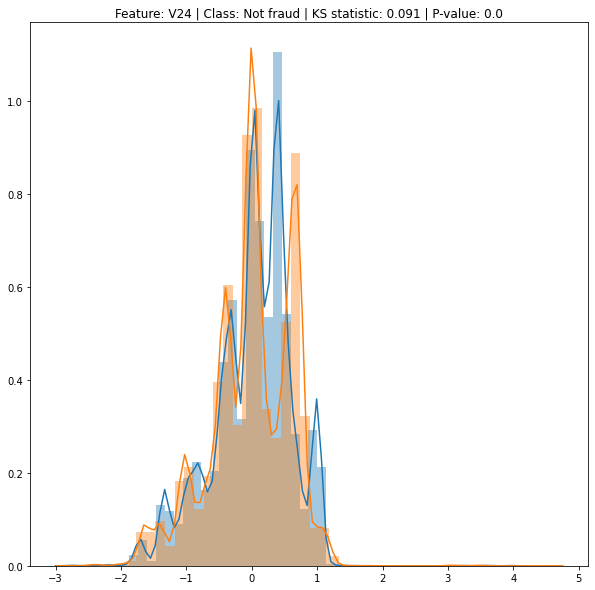

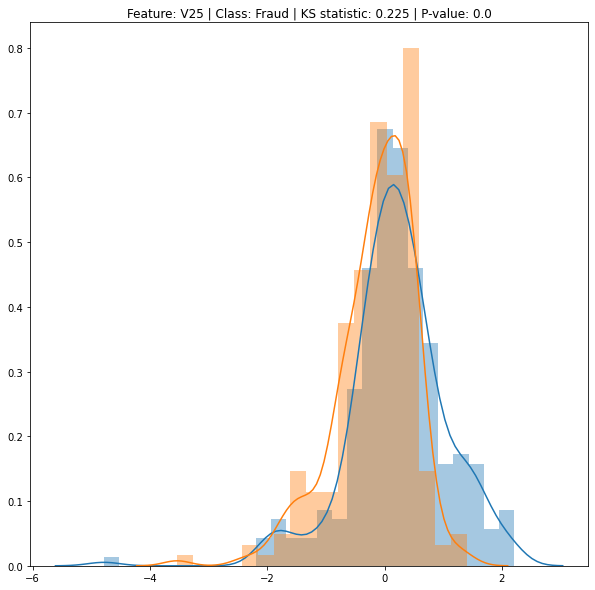

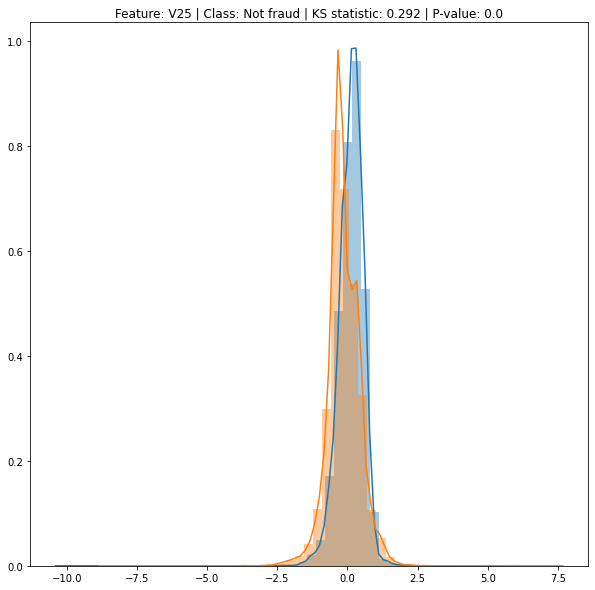

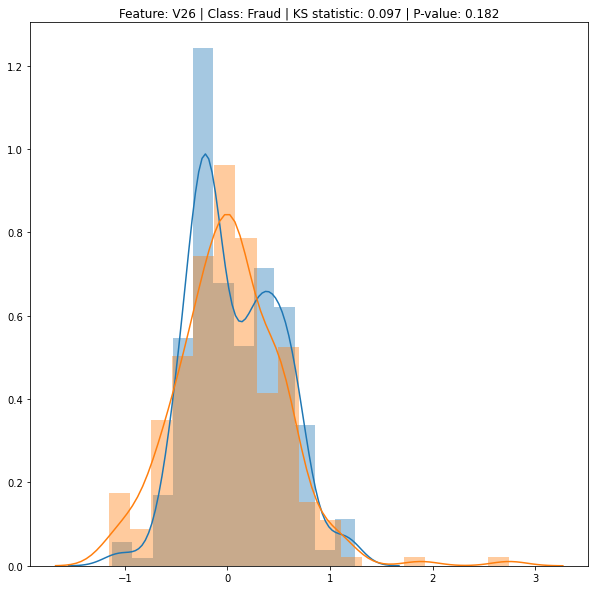

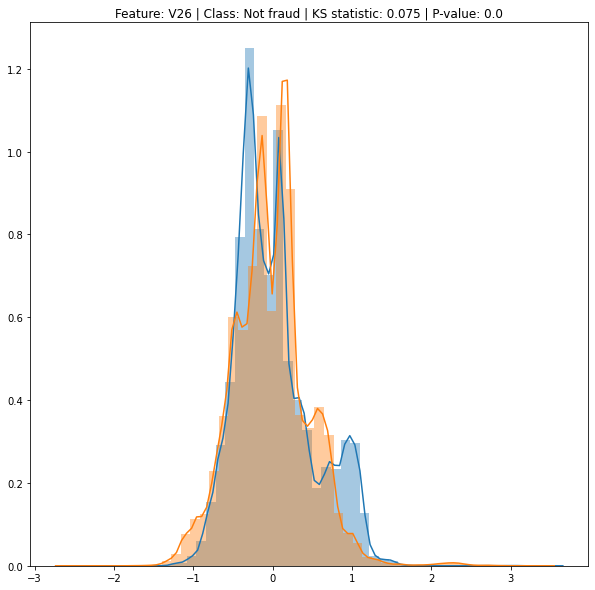

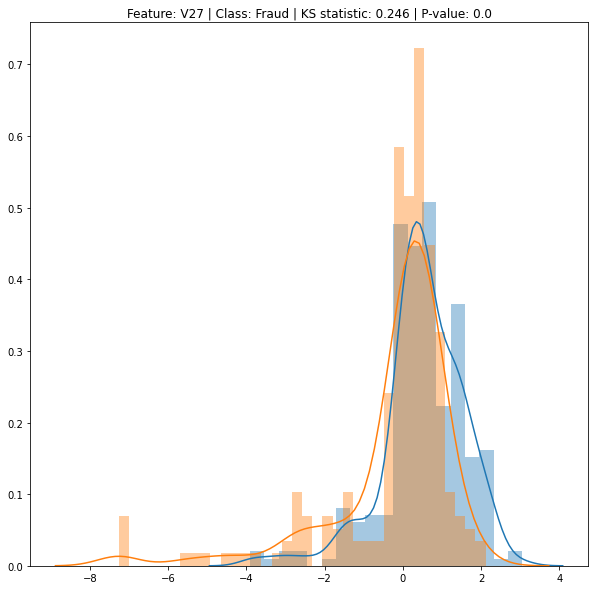

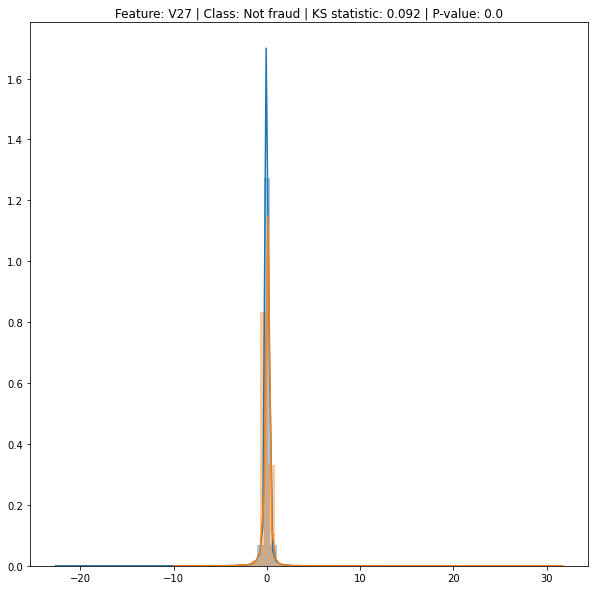

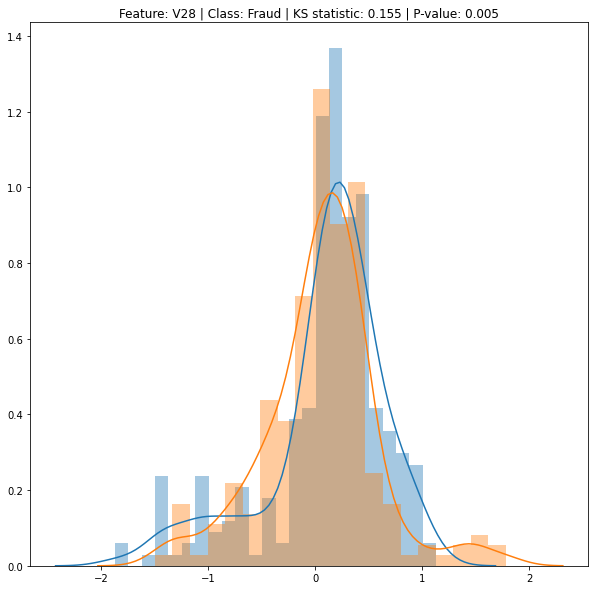

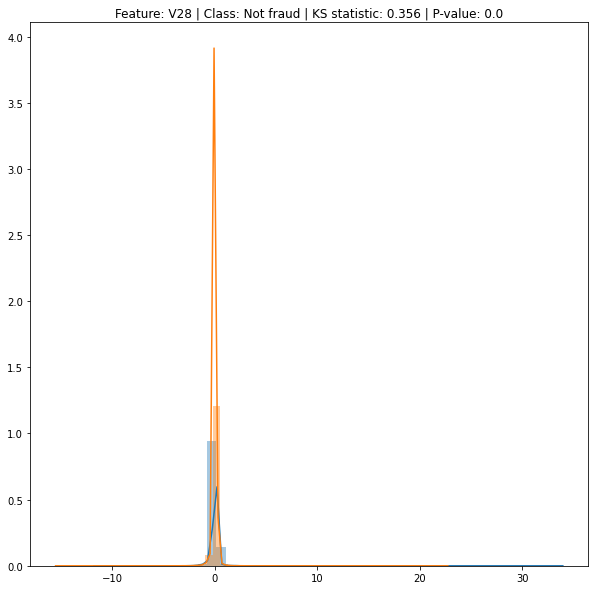

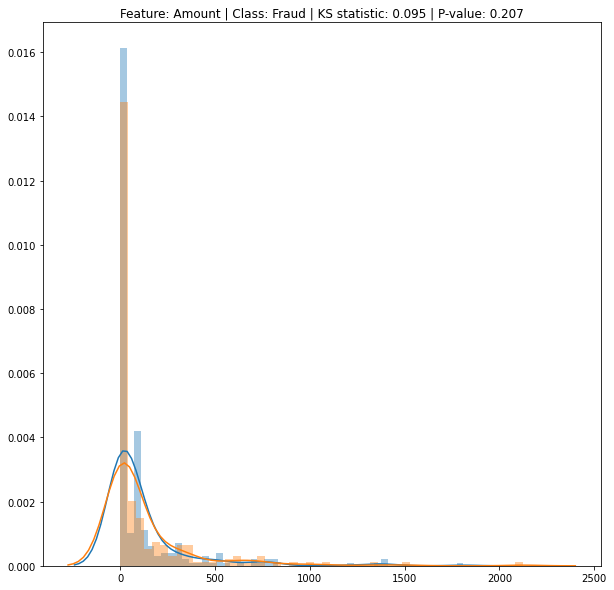

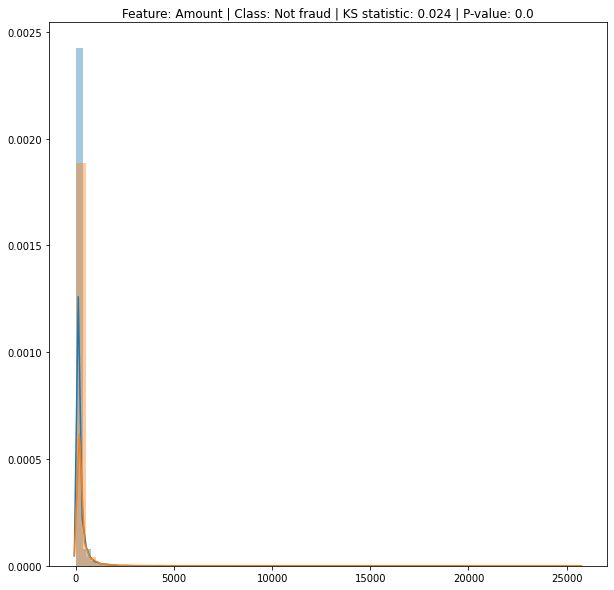

In [16]:
features = df.drop(['Class','Time'],axis=1).columns.to_list()

df_time_period_1 = df[df.Time < df.Time.median()]
df_time_period_2 = df[df.Time >= df.Time.median()]

for feature in features:
    
    #class 1
    plt.figure(figsize=(10,10))
    
    feature_period_1 = df_time_period_1[df_time_period_1.Class==1][feature].values
    feature_period_2 = df_time_period_2[df_time_period_2.Class==1][feature].values
    
    sns.distplot(feature_period_1)
    sns.distplot(feature_period_2)
    ks = kstest(feature_period_1,feature_period_2)
    plt.title(f'Feature: {feature} | Class: Fraud | KS statistic: {np.round(ks[0],3)} | P-value: {np.round(ks[1],3)}')
    
    
    #class 0
    plt.figure(figsize=(10,10))
    
    feature_period_1 = df_time_period_1[df_time_period_1.Class==0][feature].values
    feature_period_2 = df_time_period_2[df_time_period_2.Class==0][feature].values
    
    sns.distplot(feature_period_1)
    sns.distplot(feature_period_2)
    ks = kstest(feature_period_1,feature_period_2)
    plt.title(f'Feature: {feature} | Class: Not fraud | KS statistic: {np.round(ks[0],3)} | P-value: {np.round(ks[1],3)}')
    
    
    
    

In order to explore the stability of features over the time, I have spit the data over 1 time periods (before and after the median timestamp in the data), plotted distributions for both classed (fraud and non-fraud) separately and measured the Kolmagorov-Smirnov statistic between feature distibution in a future and the past. 

Most of features are stable over the time. For non-fraud events, there are feature drifts, and it's normal due to a change of beheavioral patterns of the user OR presence of new non-registered fraud events.

However, I observed that following featurs are not stable, when fraud is 100% present: V5,V6,V7,V10,V11,V12,V18,V28

They're potential candiates for for elimination